# Transfer Learning on American Sign Language

In [3]:
# set the python env so that we can use the project utils
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
!curl -L -o american_sign_language.zip https://www.kaggle.com/api/v1/datasets/download/kapillondhe/american-sign-language
!unzip -oq ./american_sign_language.zip -d "american_sign_language_dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4747M  100 4747M    0     0  37.7M      0  0:02:05  0:02:05 --:--:-- 34.9M07  0:00:27  0:01:40 35.7M37.6M      0  0:02:06  0:00:41  0:01:25 36.9M


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [5]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/kaggle/working/american_sign_language_dataset/ASL_Dataset/Test/B/3001.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (400, 400)


In [6]:
dataset_path = "/kaggle/working/american_sign_language_dataset/ASL_Dataset/Train"

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path.replace("/Train/", "/Test/"),
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
)


def normalize_image(image, label):
    precomputed_mean = [0.52732987, 0.4507709, 0.41209071]
    precomputed_std = [0.19798545, 0.23537221, 0.26049182]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 165670 files belonging to 28 classes.
Using 140820 files for training.
Using 24850 files for validation.
Found 165670 files belonging to 28 classes.
Train size: 2201. Validation size will be: 389


(64, 224, 224, 3)


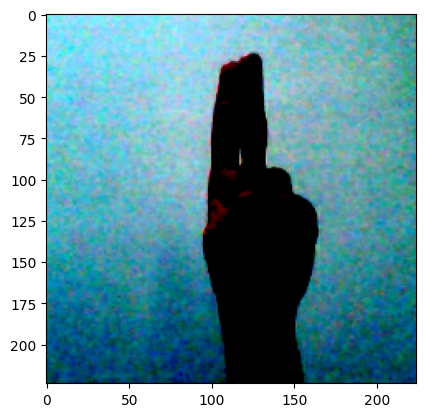

In [12]:
# Print a random image to make sure it's properly shown
images, labels = next(iter(train_dataset))

print(images.shape)

plt.imshow(images[0, :, :, :])
plt.show()

## Helper Methods

The following methods aim to make the code easier

In [32]:
from sklearn.metrics import confusion_matrix


def get_class_count(dataset):
    """Find out how many elements bellong to each class
    This method is used in plot_class_distribution to plot
    the distribution of the data
    
    Return:
        class_counts: A dictionary with the class name as a key
        and the total items as a value
    """
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    """Get how many elements belong to each class and plot them
    
    This method can help us see if there is an inbalance in the data
    """
    # Get the class counts
    class_counts = get_class_count(dataset)

    # greate an index for the dataframe
    index = list(range(len(class_counts)))
    # Create a dataframe
    df = pd.DataFrame(class_counts, index=index)
    
    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot the history returned by the training
    """

    # Convert history to a DataFrame
    history_df = pd.DataFrame(history.history)

    # Create a single figure with two subplots
    fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plotting training and validation loss
    sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax1[0])
    ax1[0].set_title('Model Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend(['Train', 'Validation'])
    
    # Plotting training and validation accuracy
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax1[1])
    ax1[1].set_title('Model Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend(['Train', 'Validation'])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 2201/2201 [03:54<00:00,  9.39it/s]


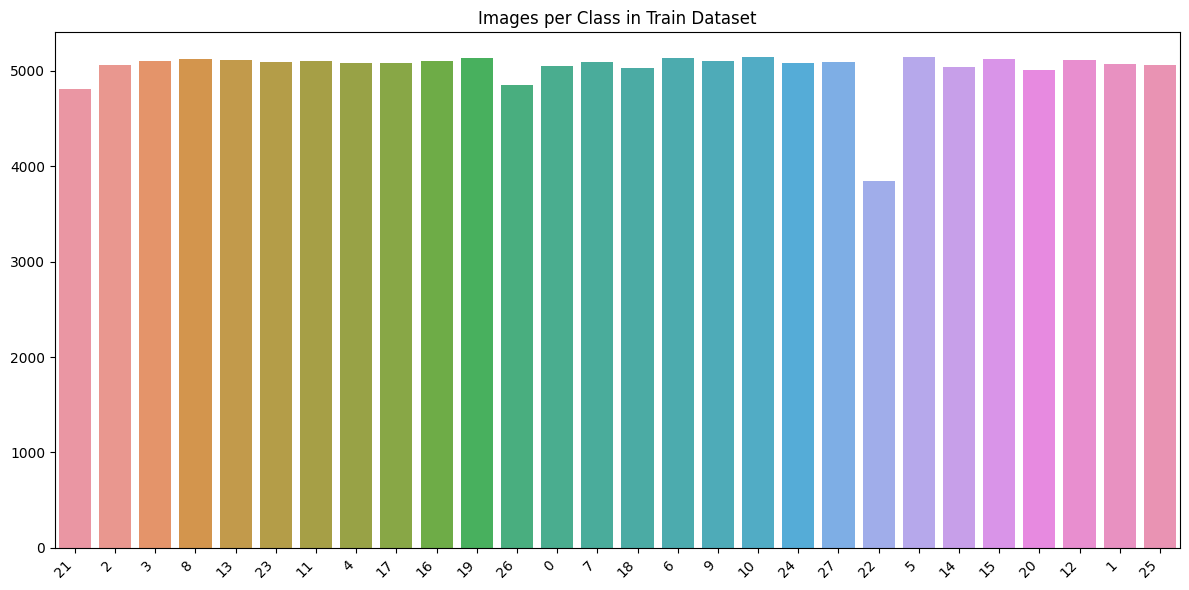

In [22]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 389/389 [00:39<00:00,  9.79it/s]


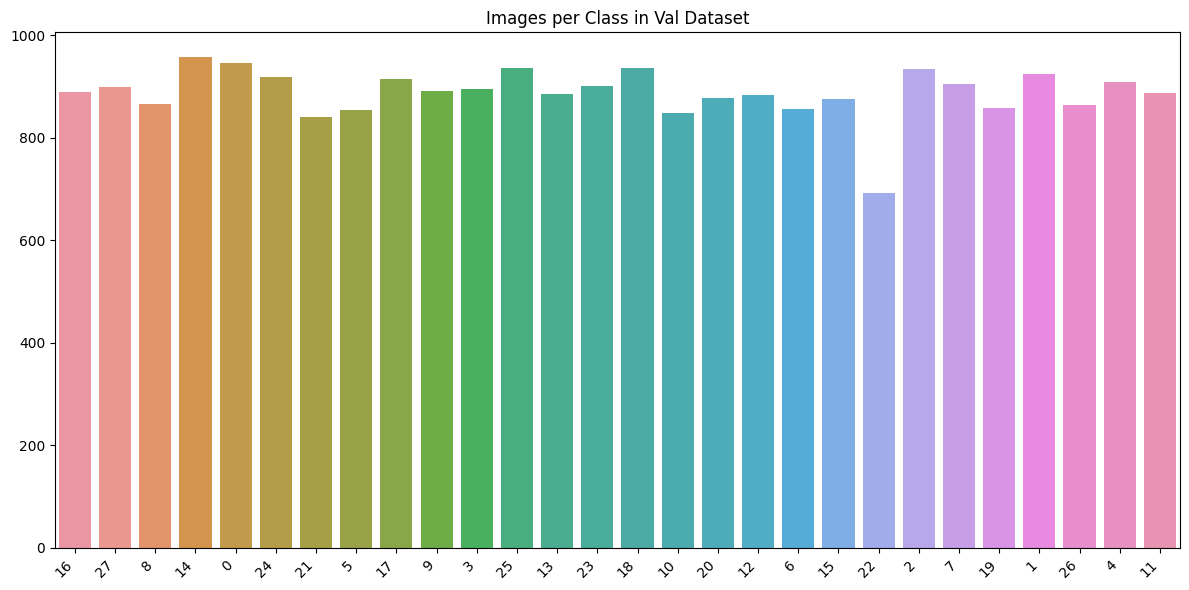

In [23]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 2589/2589 [04:23<00:00,  9.81it/s]


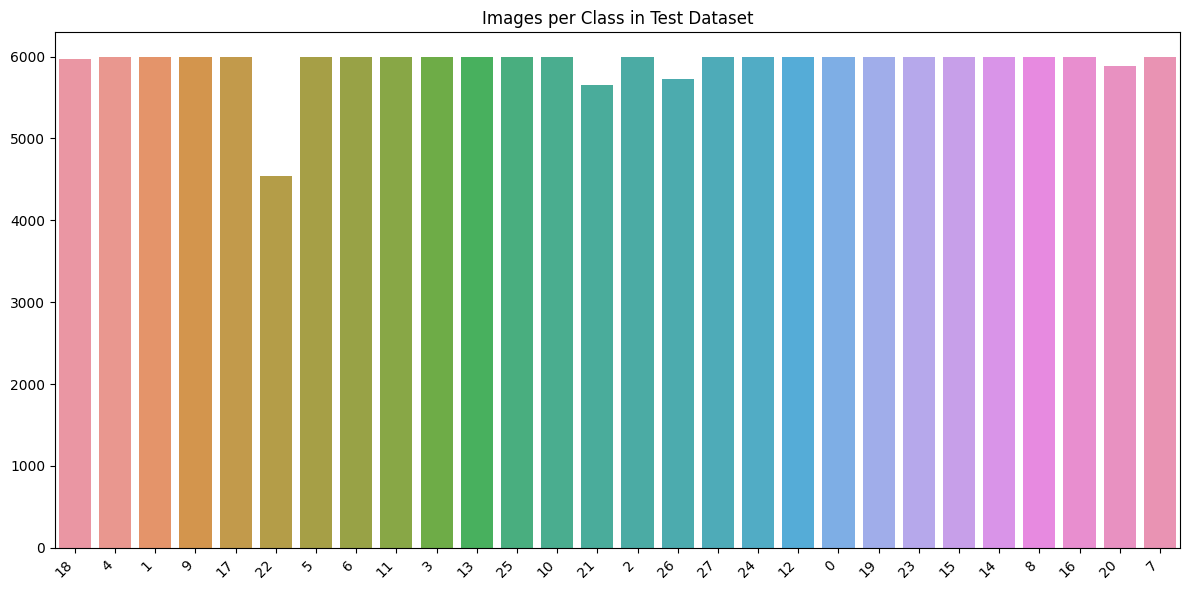

In [24]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [14]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Gathering Labels"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [15]:
class_names = get_class_names(test_dataset=test_dataset, verbose=True)

Gathering Labels: 100%|██████████| 2589/2589 [03:15<00:00, 13.27it/s]

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

We will try __different hidden sizes__ with __3 epochs__, using a __dropout__ of 0.3

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,076 (9.25 MB)

 Trainable params: 167,836 (655.61 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 203s 89ms/step - accuracy: 0.9747 - loss: 0.1441 - val_accuracy: 1.0000 - val_loss: 2.7064e-04
Epoch 2/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 190s 86ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 2.4613e-04
New best model found


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

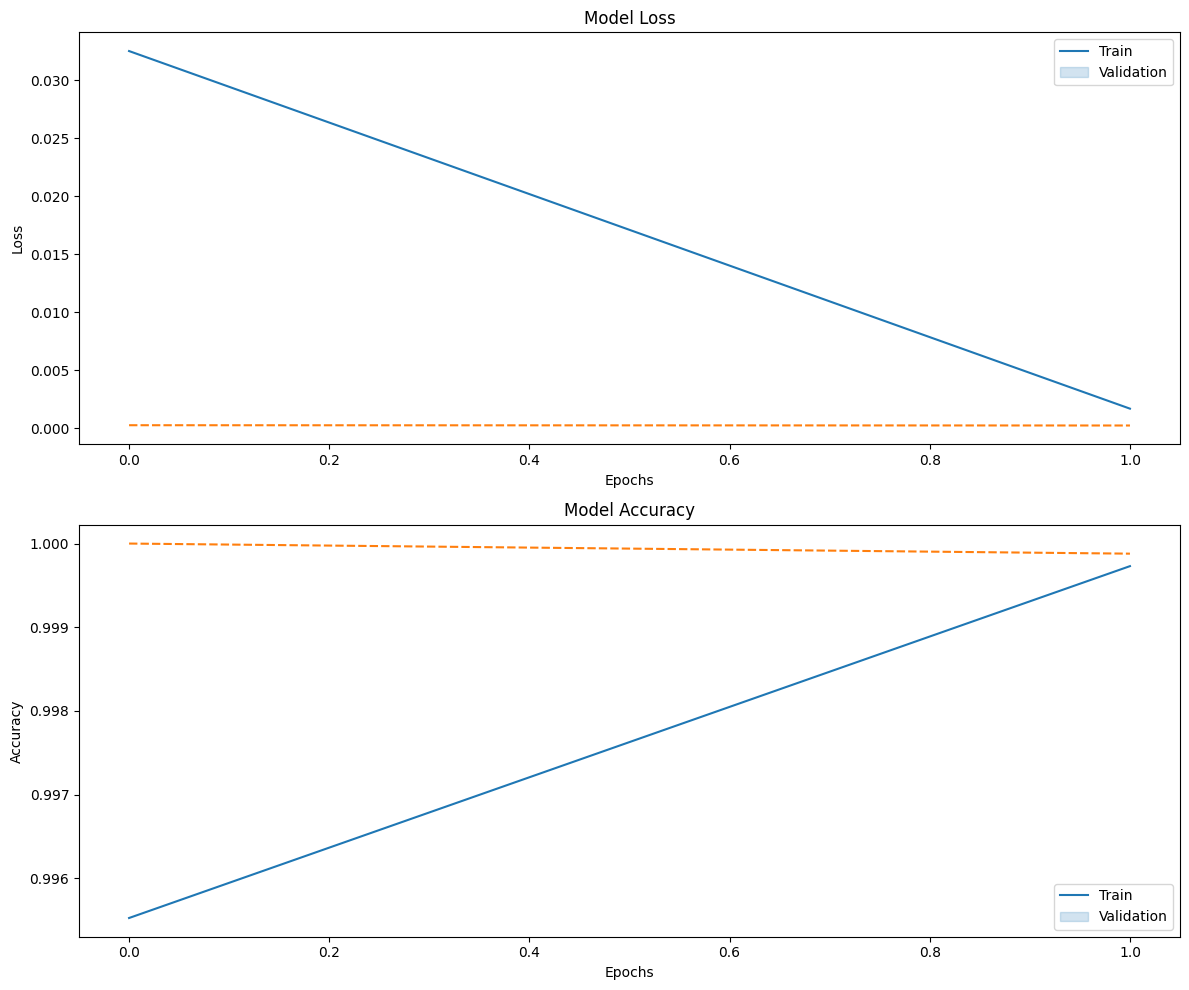

2589/2589 ━━━━━━━━━━━━━━━━━━━━ 190s 73ms/step - accuracy: 1.0000 - loss: 1.6976e-04
Test Loss: 0.00017504228162579238
Test Accuracy: 0.9999577403068542


In [22]:
hidden_sizes = [128]
best_model = None
best_acc = -1
for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # TODO add mobilenet specific preprocessing
    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,701,788 (334.56 MB)

 Trainable params: 135,068 (527.61 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 973s 432ms/step - accuracy: 0.9625 - loss: 0.1926 - val_accuracy: 1.0000 - val_loss: 1.8168e-04
Epoch 2/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 937s 425ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 2.9253e-04
New best model found


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

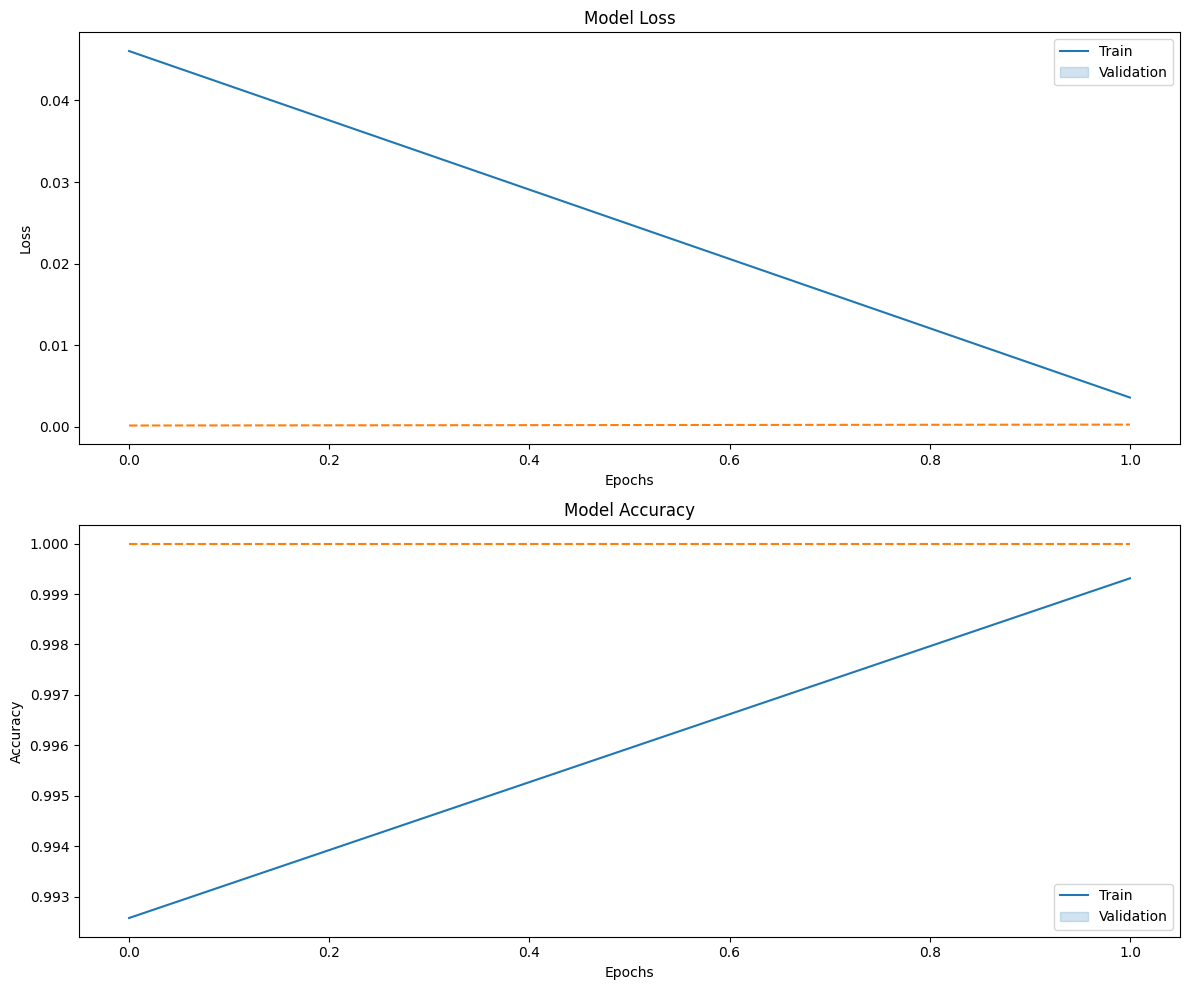

2589/2589 ━━━━━━━━━━━━━━━━━━━━ 939s 363ms/step - accuracy: 1.0000 - loss: 2.9016e-04
Test Loss: 0.0003006765618920326
Test Accuracy: 0.9999698400497437


In [23]:
hidden_sizes = [128]
best_model = None
best_acc = -1
for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

In [31]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

  0%|          | 0/2589 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  0%|          | 1/2589 [00:00<32:10,  1.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 2/2589 [00:01<24:31,  1.76it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 3/2589 [00:01<21:44,  1.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  0%|          | 4/2589 [00:02<20:31,  2.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  0%|          | 5/2589 [00:02<19:42,  2.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 6/2589 [00:02<19:33,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 7/2589 [00:03<19:15,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  0%|          | 8/2589 [00:03<19:00,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 9/2589 [00:04<18:59,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 10/2589 [00:04<18:51,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 11/2589 [00:05<18:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  0%|          | 12/2589 [00:05<18:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  1%|          | 13/2589 [00:05<18:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 14/2589 [00:06<19:03,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 15/2589 [00:06<18:59,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 16/2589 [00:07<18:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  1%|          | 17/2589 [00:07<18:37,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  1%|          | 18/2589 [00:08<18:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  1%|          | 19/2589 [00:08<18:56,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 20/2589 [00:09<18:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  1%|          | 21/2589 [00:09<18:53,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 22/2589 [00:09<18:54,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 23/2589 [00:10<19:00,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 24/2589 [00:10<18:56,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 25/2589 [00:11<18:50,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 26/2589 [00:11<18:52,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  1%|          | 27/2589 [00:12<18:46,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 28/2589 [00:12<18:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 29/2589 [00:12<18:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 30/2589 [00:13<18:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 31/2589 [00:13<18:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|          | 32/2589 [00:14<18:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  1%|▏         | 33/2589 [00:14<18:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|▏         | 34/2589 [00:15<18:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|▏         | 35/2589 [00:15<18:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|▏         | 36/2589 [00:16<18:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|▏         | 37/2589 [00:16<18:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  1%|▏         | 38/2589 [00:16<18:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 39/2589 [00:17<18:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  2%|▏         | 40/2589 [00:17<18:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  2%|▏         | 41/2589 [00:18<18:41,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 42/2589 [00:18<18:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 43/2589 [00:19<18:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 44/2589 [00:19<18:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  2%|▏         | 45/2589 [00:19<18:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 46/2589 [00:20<18:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  2%|▏         | 47/2589 [00:20<18:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 48/2589 [00:21<18:10,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 49/2589 [00:21<18:08,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 50/2589 [00:22<18:04,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 51/2589 [00:22<18:04,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 52/2589 [00:22<18:06,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 53/2589 [00:23<18:03,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 54/2589 [00:23<18:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 55/2589 [00:24<18:06,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  2%|▏         | 56/2589 [00:24<18:05,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 57/2589 [00:25<18:05,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 58/2589 [00:25<18:08,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 59/2589 [00:25<18:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 60/2589 [00:26<18:07,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 61/2589 [00:26<18:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 62/2589 [00:27<18:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 63/2589 [00:27<18:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  2%|▏         | 64/2589 [00:28<18:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 65/2589 [00:28<18:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 66/2589 [00:28<18:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 67/2589 [00:29<17:59,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  3%|▎         | 68/2589 [00:29<18:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 69/2589 [00:30<18:03,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 70/2589 [00:30<18:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 71/2589 [00:31<18:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 72/2589 [00:31<18:01,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 73/2589 [00:31<18:00,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 74/2589 [00:32<18:02,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 75/2589 [00:32<18:00,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 76/2589 [00:33<17:57,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 77/2589 [00:33<17:53,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 78/2589 [00:34<17:51,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 79/2589 [00:34<17:50,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 80/2589 [00:34<17:46,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 81/2589 [00:35<17:45,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|▎         | 82/2589 [00:35<17:51,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  3%|▎         | 83/2589 [00:36<17:54,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 84/2589 [00:36<17:49,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 85/2589 [00:37<17:46,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 86/2589 [00:37<17:56,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 87/2589 [00:37<17:50,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 88/2589 [00:38<17:46,  2.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|▎         | 89/2589 [00:38<17:52,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  3%|▎         | 90/2589 [00:39<17:51,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▎         | 91/2589 [00:39<17:50,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▎         | 92/2589 [00:40<17:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▎         | 93/2589 [00:40<18:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▎         | 94/2589 [00:41<18:22,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▎         | 95/2589 [00:41<18:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  4%|▎         | 96/2589 [00:41<18:17,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▎         | 97/2589 [00:42<18:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 98/2589 [00:42<18:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 99/2589 [00:43<18:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 100/2589 [00:43<17:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 101/2589 [00:44<18:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 102/2589 [00:44<18:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 103/2589 [00:44<18:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 104/2589 [00:45<17:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  4%|▍         | 105/2589 [00:45<17:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 106/2589 [00:46<17:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▍         | 107/2589 [00:46<17:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▍         | 108/2589 [00:47<17:45,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 109/2589 [00:47<17:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 110/2589 [00:47<17:48,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 111/2589 [00:48<17:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 112/2589 [00:48<17:42,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 113/2589 [00:49<17:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 114/2589 [00:49<17:48,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  4%|▍         | 115/2589 [00:50<17:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|▍         | 116/2589 [00:50<17:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 117/2589 [00:50<17:56,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|▍         | 118/2589 [00:51<17:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 119/2589 [00:51<17:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 120/2589 [00:52<17:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  5%|▍         | 121/2589 [00:52<17:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 122/2589 [00:53<17:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 123/2589 [00:53<17:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|▍         | 124/2589 [00:54<17:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 125/2589 [00:54<17:54,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 126/2589 [00:54<17:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 127/2589 [00:55<17:41,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 128/2589 [00:55<17:36,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▍         | 129/2589 [00:56<17:37,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 130/2589 [00:56<17:36,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 131/2589 [00:57<17:43,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 132/2589 [00:57<17:39,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  5%|▌         | 133/2589 [00:57<17:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 134/2589 [00:58<17:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 135/2589 [00:58<17:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|▌         | 136/2589 [00:59<17:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  5%|▌         | 137/2589 [00:59<17:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 138/2589 [01:00<17:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 139/2589 [01:00<17:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 140/2589 [01:00<17:32,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 141/2589 [01:01<17:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  5%|▌         | 142/2589 [01:01<17:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 143/2589 [01:02<17:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 144/2589 [01:02<17:34,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 145/2589 [01:03<17:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 146/2589 [01:03<17:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 147/2589 [01:03<17:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 148/2589 [01:04<17:32,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 149/2589 [01:04<17:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 150/2589 [01:05<17:32,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 151/2589 [01:05<17:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 152/2589 [01:06<17:42,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 153/2589 [01:06<17:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 154/2589 [01:07<17:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 155/2589 [01:07<17:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 156/2589 [01:07<17:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 157/2589 [01:08<17:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|▌         | 158/2589 [01:08<17:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  6%|▌         | 159/2589 [01:09<17:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  6%|▌         | 160/2589 [01:09<17:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▌         | 161/2589 [01:10<17:37,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  6%|▋         | 162/2589 [01:10<17:40,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▋         | 163/2589 [01:10<17:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▋         | 164/2589 [01:11<17:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  6%|▋         | 165/2589 [01:11<17:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▋         | 166/2589 [01:12<17:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▋         | 167/2589 [01:12<17:50,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|▋         | 168/2589 [01:13<17:47,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 169/2589 [01:13<17:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 170/2589 [01:14<17:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 171/2589 [01:14<17:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  7%|▋         | 172/2589 [01:14<17:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 173/2589 [01:15<17:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 174/2589 [01:15<17:16,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 175/2589 [01:16<17:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 176/2589 [01:16<17:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 177/2589 [01:17<17:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 178/2589 [01:17<17:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 179/2589 [01:17<17:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 180/2589 [01:18<17:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 181/2589 [01:18<17:30,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 182/2589 [01:19<17:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 183/2589 [01:19<17:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 184/2589 [01:20<17:17,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 185/2589 [01:20<17:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 186/2589 [01:20<17:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 187/2589 [01:21<17:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 188/2589 [01:21<17:09,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 189/2589 [01:22<17:07,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 190/2589 [01:22<17:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|▋         | 191/2589 [01:23<17:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 192/2589 [01:23<17:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  7%|▋         | 193/2589 [01:23<17:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|▋         | 194/2589 [01:24<17:09,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 195/2589 [01:24<17:06,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 196/2589 [01:25<17:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|▊         | 197/2589 [01:25<17:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|▊         | 198/2589 [01:26<17:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 199/2589 [01:26<17:24,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 200/2589 [01:26<17:29,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  8%|▊         | 201/2589 [01:27<17:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 202/2589 [01:27<17:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 203/2589 [01:28<17:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 204/2589 [01:28<17:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 205/2589 [01:29<17:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|▊         | 206/2589 [01:29<17:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 207/2589 [01:30<17:18,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|▊         | 208/2589 [01:30<17:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 209/2589 [01:30<17:18,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 210/2589 [01:31<17:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 211/2589 [01:31<17:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 212/2589 [01:32<17:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 213/2589 [01:32<17:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  8%|▊         | 214/2589 [01:33<17:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 215/2589 [01:33<17:03,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 216/2589 [01:33<17:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 217/2589 [01:34<17:02,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  8%|▊         | 218/2589 [01:34<17:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 219/2589 [01:35<17:04,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  8%|▊         | 220/2589 [01:35<17:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 221/2589 [01:36<17:18,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 222/2589 [01:36<17:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 223/2589 [01:36<17:22,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 224/2589 [01:37<17:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 225/2589 [01:37<17:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▊         | 226/2589 [01:38<17:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 227/2589 [01:38<17:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 228/2589 [01:39<17:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 229/2589 [01:39<16:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 230/2589 [01:40<17:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 231/2589 [01:40<17:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 232/2589 [01:40<16:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 233/2589 [01:41<17:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 234/2589 [01:41<17:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  9%|▉         | 235/2589 [01:42<17:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  9%|▉         | 236/2589 [01:42<17:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 237/2589 [01:43<16:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  9%|▉         | 238/2589 [01:43<16:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  9%|▉         | 239/2589 [01:43<17:20,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  9%|▉         | 240/2589 [01:44<17:28,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 241/2589 [01:44<17:40,  2.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 242/2589 [01:45<17:33,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 243/2589 [01:45<17:26,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  9%|▉         | 244/2589 [01:46<17:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  9%|▉         | 245/2589 [01:46<17:15,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 246/2589 [01:47<17:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|▉         | 247/2589 [01:47<17:09,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 248/2589 [01:47<17:03,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|▉         | 249/2589 [01:48<17:05,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|▉         | 250/2589 [01:48<17:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 251/2589 [01:49<17:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 252/2589 [01:49<17:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 253/2589 [01:50<17:13,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|▉         | 254/2589 [01:50<17:07,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|▉         | 255/2589 [01:51<17:12,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|▉         | 256/2589 [01:51<17:04,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 10%|▉         | 257/2589 [01:51<17:15,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|▉         | 258/2589 [01:52<17:11,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 259/2589 [01:52<16:59,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 10%|█         | 260/2589 [01:53<17:04,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 261/2589 [01:53<16:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 262/2589 [01:54<16:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|█         | 263/2589 [01:54<17:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 264/2589 [01:54<17:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 265/2589 [01:55<16:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 266/2589 [01:55<16:54,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 267/2589 [01:56<17:03,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|█         | 268/2589 [01:56<16:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 269/2589 [01:57<16:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 270/2589 [01:57<16:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 10%|█         | 271/2589 [01:58<16:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 272/2589 [01:58<16:43,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 273/2589 [01:58<16:54,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 274/2589 [01:59<16:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 275/2589 [01:59<16:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 11%|█         | 276/2589 [02:00<16:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 277/2589 [02:00<16:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 278/2589 [02:01<16:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 279/2589 [02:01<16:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 280/2589 [02:01<16:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 281/2589 [02:02<16:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 282/2589 [02:02<16:29,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 283/2589 [02:03<16:31,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 284/2589 [02:03<16:30,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 285/2589 [02:04<16:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 286/2589 [02:04<16:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 287/2589 [02:04<16:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 288/2589 [02:05<16:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 289/2589 [02:05<16:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█         | 290/2589 [02:06<16:31,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█         | 291/2589 [02:06<16:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█▏        | 292/2589 [02:07<16:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 11%|█▏        | 293/2589 [02:07<16:28,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█▏        | 294/2589 [02:07<16:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|█▏        | 295/2589 [02:08<16:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 11%|█▏        | 296/2589 [02:08<16:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 11%|█▏        | 297/2589 [02:09<16:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 298/2589 [02:09<16:47,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█▏        | 299/2589 [02:10<16:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 300/2589 [02:10<16:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 12%|█▏        | 301/2589 [02:11<16:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 302/2589 [02:11<16:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 303/2589 [02:11<16:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 304/2589 [02:12<16:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█▏        | 305/2589 [02:12<16:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 306/2589 [02:13<16:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 307/2589 [02:13<16:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 12%|█▏        | 308/2589 [02:14<16:21,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 309/2589 [02:14<16:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 310/2589 [02:14<16:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 311/2589 [02:15<16:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 12%|█▏        | 312/2589 [02:15<16:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 313/2589 [02:16<16:46,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█▏        | 314/2589 [02:16<16:46,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 12%|█▏        | 315/2589 [02:17<17:02,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 316/2589 [02:17<16:53,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 317/2589 [02:18<16:50,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 318/2589 [02:18<16:44,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 319/2589 [02:18<16:41,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 320/2589 [02:19<16:33,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 12%|█▏        | 321/2589 [02:19<16:36,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 12%|█▏        | 322/2589 [02:20<16:38,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 12%|█▏        | 323/2589 [02:20<16:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 13%|█▎        | 324/2589 [02:21<16:32,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|█▎        | 325/2589 [02:21<16:38,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 326/2589 [02:21<16:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 327/2589 [02:22<16:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 328/2589 [02:22<16:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 329/2589 [02:23<16:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 13%|█▎        | 330/2589 [02:23<16:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|█▎        | 331/2589 [02:24<16:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 332/2589 [02:24<16:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|█▎        | 333/2589 [02:25<16:25,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 13%|█▎        | 334/2589 [02:25<16:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 335/2589 [02:25<16:30,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 336/2589 [02:26<16:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 337/2589 [02:26<16:27,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|█▎        | 338/2589 [02:27<16:25,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 339/2589 [02:27<16:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 340/2589 [02:28<16:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 341/2589 [02:28<16:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 13%|█▎        | 342/2589 [02:28<16:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 343/2589 [02:29<16:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 344/2589 [02:29<16:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 345/2589 [02:30<16:18,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 346/2589 [02:30<16:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 347/2589 [02:31<16:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 13%|█▎        | 348/2589 [02:31<16:24,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 13%|█▎        | 349/2589 [02:32<16:24,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 14%|█▎        | 350/2589 [02:32<16:22,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▎        | 351/2589 [02:32<16:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▎        | 352/2589 [02:33<16:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▎        | 353/2589 [02:33<16:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▎        | 354/2589 [02:34<16:05,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▎        | 355/2589 [02:34<16:02,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 14%|█▍        | 356/2589 [02:35<16:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 357/2589 [02:35<16:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 358/2589 [02:35<16:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 359/2589 [02:36<16:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▍        | 360/2589 [02:36<15:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 361/2589 [02:37<15:54,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 362/2589 [02:37<15:54,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▍        | 363/2589 [02:38<16:26,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 364/2589 [02:38<16:18,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▍        | 365/2589 [02:38<16:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 366/2589 [02:39<16:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|█▍        | 367/2589 [02:39<16:25,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 368/2589 [02:40<16:12,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|█▍        | 369/2589 [02:40<16:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▍        | 370/2589 [02:41<16:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 371/2589 [02:41<16:11,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 372/2589 [02:42<16:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 14%|█▍        | 373/2589 [02:42<16:12,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|█▍        | 374/2589 [02:42<16:09,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 14%|█▍        | 375/2589 [02:43<16:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 376/2589 [02:43<16:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 377/2589 [02:44<16:04,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 378/2589 [02:44<16:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 379/2589 [02:45<16:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▍        | 380/2589 [02:45<16:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 381/2589 [02:45<16:10,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 382/2589 [02:46<16:09,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 383/2589 [02:46<15:59,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▍        | 384/2589 [02:47<15:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 385/2589 [02:47<15:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▍        | 386/2589 [02:48<16:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▍        | 387/2589 [02:48<16:09,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▍        | 388/2589 [02:49<16:12,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 389/2589 [02:49<16:08,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 390/2589 [02:49<16:08,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 391/2589 [02:50<15:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 392/2589 [02:50<16:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 393/2589 [02:51<16:08,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 394/2589 [02:51<16:06,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 15%|█▌        | 395/2589 [02:52<16:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 396/2589 [02:52<15:59,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 397/2589 [02:52<15:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 398/2589 [02:53<15:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 399/2589 [02:53<15:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 15%|█▌        | 400/2589 [02:54<15:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|█▌        | 401/2589 [02:54<15:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 402/2589 [02:55<15:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 403/2589 [02:55<15:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 404/2589 [02:55<15:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 405/2589 [02:56<15:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 16%|█▌        | 406/2589 [02:56<15:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 407/2589 [02:57<15:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 408/2589 [02:57<15:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 409/2589 [02:58<15:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 410/2589 [02:58<15:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 411/2589 [02:59<15:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 412/2589 [02:59<15:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 413/2589 [02:59<15:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 414/2589 [03:00<15:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 415/2589 [03:00<15:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 416/2589 [03:01<15:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 417/2589 [03:01<15:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▌        | 418/2589 [03:02<15:51,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 419/2589 [03:02<15:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▌        | 420/2589 [03:02<15:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▋        | 421/2589 [03:03<15:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▋        | 422/2589 [03:03<15:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▋        | 423/2589 [03:04<15:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▋        | 424/2589 [03:04<15:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|█▋        | 425/2589 [03:05<15:49,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▋        | 426/2589 [03:05<15:48,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 16%|█▋        | 427/2589 [03:06<15:55,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 428/2589 [03:06<15:54,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 17%|█▋        | 429/2589 [03:06<15:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 430/2589 [03:07<15:52,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 431/2589 [03:07<15:42,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 432/2589 [03:08<15:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 433/2589 [03:08<15:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 434/2589 [03:09<15:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 435/2589 [03:09<15:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 436/2589 [03:09<15:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 437/2589 [03:10<15:26,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 438/2589 [03:10<15:24,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 439/2589 [03:11<15:24,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 440/2589 [03:11<15:26,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 441/2589 [03:12<15:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 442/2589 [03:12<15:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 443/2589 [03:13<15:45,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 444/2589 [03:13<15:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 445/2589 [03:13<15:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 446/2589 [03:14<15:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 447/2589 [03:14<15:44,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|█▋        | 448/2589 [03:15<15:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 449/2589 [03:15<15:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 17%|█▋        | 450/2589 [03:16<15:35,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 17%|█▋        | 451/2589 [03:16<15:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 17%|█▋        | 452/2589 [03:16<15:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█▋        | 453/2589 [03:17<15:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 454/2589 [03:17<15:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 455/2589 [03:18<15:34,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 456/2589 [03:18<15:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 457/2589 [03:19<15:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 458/2589 [03:19<15:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 459/2589 [03:20<15:44,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 460/2589 [03:20<15:44,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 461/2589 [03:20<15:53,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 462/2589 [03:21<15:47,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 18%|█▊        | 463/2589 [03:21<15:43,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 464/2589 [03:22<15:33,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 18%|█▊        | 465/2589 [03:22<15:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 466/2589 [03:23<15:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 467/2589 [03:23<15:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 468/2589 [03:23<15:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 469/2589 [03:24<15:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 470/2589 [03:24<15:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 471/2589 [03:25<15:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 472/2589 [03:25<15:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 473/2589 [03:26<15:27,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 474/2589 [03:26<15:33,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 475/2589 [03:27<15:32,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 476/2589 [03:27<15:25,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 18%|█▊        | 477/2589 [03:27<15:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 18%|█▊        | 478/2589 [03:28<15:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▊        | 479/2589 [03:28<15:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▊        | 480/2589 [03:29<15:29,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 19%|█▊        | 481/2589 [03:29<15:25,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▊        | 482/2589 [03:30<15:23,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▊        | 483/2589 [03:30<15:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▊        | 484/2589 [03:30<15:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▊        | 485/2589 [03:31<15:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 19%|█▉        | 486/2589 [03:31<15:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 487/2589 [03:32<15:05,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 488/2589 [03:32<15:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 489/2589 [03:33<15:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 19%|█▉        | 490/2589 [03:33<15:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 491/2589 [03:33<15:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 492/2589 [03:34<15:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 493/2589 [03:34<15:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 494/2589 [03:35<15:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 495/2589 [03:35<15:25,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 496/2589 [03:36<15:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 497/2589 [03:36<15:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 498/2589 [03:37<15:13,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 499/2589 [03:37<15:22,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 500/2589 [03:37<15:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 501/2589 [03:38<15:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 19%|█▉        | 502/2589 [03:38<15:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 503/2589 [03:39<15:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|█▉        | 504/2589 [03:39<15:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 505/2589 [03:40<15:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 20%|█▉        | 506/2589 [03:40<15:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 507/2589 [03:40<15:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 508/2589 [03:41<15:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 509/2589 [03:41<15:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|█▉        | 510/2589 [03:42<15:05,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|█▉        | 511/2589 [03:42<15:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|█▉        | 512/2589 [03:43<15:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 513/2589 [03:43<15:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|█▉        | 514/2589 [03:44<15:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 515/2589 [03:44<15:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 516/2589 [03:44<15:14,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|█▉        | 517/2589 [03:45<15:08,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 518/2589 [03:45<15:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 519/2589 [03:46<14:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|██        | 520/2589 [03:46<14:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 521/2589 [03:47<14:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 522/2589 [03:47<14:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 523/2589 [03:47<14:56,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 524/2589 [03:48<14:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|██        | 525/2589 [03:48<14:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 526/2589 [03:49<14:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 20%|██        | 527/2589 [03:49<14:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 20%|██        | 528/2589 [03:50<14:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 20%|██        | 529/2589 [03:50<14:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 20%|██        | 530/2589 [03:50<14:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██        | 531/2589 [03:51<15:06,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 21%|██        | 532/2589 [03:51<15:19,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 21%|██        | 533/2589 [03:52<15:33,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 534/2589 [03:52<15:26,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 535/2589 [03:53<15:34,  2.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 536/2589 [03:53<15:23,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 537/2589 [03:54<15:07,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 538/2589 [03:54<14:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|██        | 539/2589 [03:54<14:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 21%|██        | 540/2589 [03:55<14:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 541/2589 [03:55<14:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 542/2589 [03:56<14:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 543/2589 [03:56<14:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 544/2589 [03:57<14:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██        | 545/2589 [03:57<14:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 546/2589 [03:58<14:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██        | 547/2589 [03:58<14:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 548/2589 [03:58<14:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██        | 549/2589 [03:59<14:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██        | 550/2589 [03:59<14:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██▏       | 551/2589 [04:00<14:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██▏       | 552/2589 [04:00<14:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 21%|██▏       | 553/2589 [04:01<14:34,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██▏       | 554/2589 [04:01<14:32,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 21%|██▏       | 555/2589 [04:01<14:33,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|██▏       | 556/2589 [04:02<14:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 557/2589 [04:02<14:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 558/2589 [04:03<14:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 559/2589 [04:03<14:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 560/2589 [04:04<14:48,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 561/2589 [04:04<14:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 562/2589 [04:04<14:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 563/2589 [04:05<14:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 564/2589 [04:05<14:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 565/2589 [04:06<14:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 566/2589 [04:06<14:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 567/2589 [04:07<14:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 22%|██▏       | 568/2589 [04:07<14:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 569/2589 [04:08<14:52,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 570/2589 [04:08<14:51,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 571/2589 [04:08<14:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 572/2589 [04:09<14:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 573/2589 [04:09<14:32,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 574/2589 [04:10<14:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 575/2589 [04:10<14:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 576/2589 [04:11<14:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 577/2589 [04:11<14:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 578/2589 [04:11<14:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 22%|██▏       | 579/2589 [04:12<14:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 580/2589 [04:12<14:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 581/2589 [04:13<14:44,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|██▏       | 582/2589 [04:13<14:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|██▎       | 583/2589 [04:14<14:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 584/2589 [04:14<14:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 585/2589 [04:14<14:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 586/2589 [04:15<14:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 587/2589 [04:15<14:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 588/2589 [04:16<14:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 589/2589 [04:16<14:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 590/2589 [04:17<14:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 591/2589 [04:17<14:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 592/2589 [04:18<14:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██▎       | 593/2589 [04:18<14:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|██▎       | 594/2589 [04:18<14:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 595/2589 [04:19<14:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 596/2589 [04:19<14:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 597/2589 [04:20<14:13,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 598/2589 [04:20<14:16,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 599/2589 [04:21<14:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██▎       | 600/2589 [04:21<14:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 601/2589 [04:21<14:17,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 602/2589 [04:22<14:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 603/2589 [04:22<14:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 23%|██▎       | 604/2589 [04:23<14:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 605/2589 [04:23<14:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 606/2589 [04:24<14:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 607/2589 [04:24<14:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|██▎       | 608/2589 [04:24<14:32,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▎       | 609/2589 [04:25<14:25,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▎       | 610/2589 [04:25<14:29,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▎       | 611/2589 [04:26<14:24,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▎       | 612/2589 [04:26<14:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▎       | 613/2589 [04:27<14:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▎       | 614/2589 [04:27<14:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 615/2589 [04:27<14:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 616/2589 [04:28<14:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 617/2589 [04:28<14:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 618/2589 [04:29<14:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 619/2589 [04:29<14:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 620/2589 [04:30<14:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 621/2589 [04:30<14:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 622/2589 [04:31<14:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 623/2589 [04:31<14:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 24%|██▍       | 624/2589 [04:31<14:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 625/2589 [04:32<14:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 626/2589 [04:32<14:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 627/2589 [04:33<14:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 628/2589 [04:33<14:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 629/2589 [04:34<14:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 630/2589 [04:34<14:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 631/2589 [04:34<14:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 632/2589 [04:35<14:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 24%|██▍       | 633/2589 [04:35<14:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 24%|██▍       | 634/2589 [04:36<14:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 635/2589 [04:36<14:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▍       | 636/2589 [04:37<14:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▍       | 637/2589 [04:37<14:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██▍       | 638/2589 [04:37<14:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 639/2589 [04:38<14:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 640/2589 [04:38<14:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▍       | 641/2589 [04:39<14:02,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 25%|██▍       | 642/2589 [04:39<14:02,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 25%|██▍       | 643/2589 [04:40<13:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 644/2589 [04:40<13:55,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 645/2589 [04:41<13:54,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▍       | 646/2589 [04:41<14:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▍       | 647/2589 [04:41<14:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 648/2589 [04:42<14:05,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 649/2589 [04:42<14:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 650/2589 [04:43<14:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 651/2589 [04:43<13:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 652/2589 [04:44<13:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 653/2589 [04:44<13:55,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 654/2589 [04:44<13:55,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 655/2589 [04:45<13:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██▌       | 656/2589 [04:45<14:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 657/2589 [04:46<14:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 658/2589 [04:46<14:03,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 659/2589 [04:47<13:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|██▌       | 660/2589 [04:47<13:52,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 661/2589 [04:47<13:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▌       | 662/2589 [04:48<13:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▌       | 663/2589 [04:48<13:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 664/2589 [04:49<13:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▌       | 665/2589 [04:49<13:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 666/2589 [04:50<13:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 667/2589 [04:50<13:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 668/2589 [04:50<13:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 669/2589 [04:51<13:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▌       | 670/2589 [04:51<13:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 671/2589 [04:52<13:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▌       | 672/2589 [04:52<13:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 673/2589 [04:53<13:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 674/2589 [04:53<13:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 675/2589 [04:54<13:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▌       | 676/2589 [04:54<13:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▌       | 677/2589 [04:54<13:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▌       | 678/2589 [04:55<13:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▌       | 679/2589 [04:55<14:05,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 26%|██▋       | 680/2589 [04:56<14:06,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▋       | 681/2589 [04:56<14:06,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▋       | 682/2589 [04:57<14:08,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 26%|██▋       | 683/2589 [04:57<14:02,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▋       | 684/2589 [04:58<14:02,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 26%|██▋       | 685/2589 [04:58<13:59,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 26%|██▋       | 686/2589 [04:58<13:56,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 687/2589 [04:59<13:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 688/2589 [04:59<13:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 689/2589 [05:00<13:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 690/2589 [05:00<13:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 691/2589 [05:01<13:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 692/2589 [05:01<13:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 693/2589 [05:01<13:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 694/2589 [05:02<13:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 695/2589 [05:02<13:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 696/2589 [05:03<13:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 697/2589 [05:03<13:36,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 698/2589 [05:04<13:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 699/2589 [05:04<13:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 700/2589 [05:04<13:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 701/2589 [05:05<13:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 702/2589 [05:05<13:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 703/2589 [05:06<13:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 704/2589 [05:06<13:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 705/2589 [05:07<13:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 706/2589 [05:07<13:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 27%|██▋       | 707/2589 [05:08<13:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 708/2589 [05:08<13:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 27%|██▋       | 709/2589 [05:08<13:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 710/2589 [05:09<13:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 27%|██▋       | 711/2589 [05:09<13:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 712/2589 [05:10<13:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 713/2589 [05:10<13:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 714/2589 [05:11<13:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 715/2589 [05:11<13:32,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 716/2589 [05:11<13:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 717/2589 [05:12<13:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 718/2589 [05:12<13:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 719/2589 [05:13<13:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 720/2589 [05:13<13:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 721/2589 [05:14<13:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 722/2589 [05:14<13:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 723/2589 [05:14<13:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 724/2589 [05:15<13:34,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 28%|██▊       | 725/2589 [05:15<13:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 726/2589 [05:16<13:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 727/2589 [05:16<13:21,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 728/2589 [05:17<13:19,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 729/2589 [05:17<13:15,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 730/2589 [05:17<13:18,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 731/2589 [05:18<13:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 732/2589 [05:18<13:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 28%|██▊       | 733/2589 [05:19<13:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 734/2589 [05:19<13:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|██▊       | 735/2589 [05:20<13:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 736/2589 [05:20<13:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 28%|██▊       | 737/2589 [05:21<13:35,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▊       | 738/2589 [05:21<13:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▊       | 739/2589 [05:21<13:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▊       | 740/2589 [05:22<13:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▊       | 741/2589 [05:22<13:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▊       | 742/2589 [05:23<13:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▊       | 743/2589 [05:23<13:20,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▊       | 744/2589 [05:24<13:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 745/2589 [05:24<13:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 746/2589 [05:24<13:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 747/2589 [05:25<13:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 748/2589 [05:25<13:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 749/2589 [05:26<13:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 750/2589 [05:26<13:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 751/2589 [05:27<13:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 752/2589 [05:27<13:24,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 29%|██▉       | 753/2589 [05:28<13:33,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 754/2589 [05:28<13:37,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 755/2589 [05:28<13:36,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 756/2589 [05:29<13:31,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 757/2589 [05:29<13:29,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 758/2589 [05:30<13:24,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 29%|██▉       | 759/2589 [05:30<13:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 760/2589 [05:31<13:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 761/2589 [05:31<13:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 29%|██▉       | 762/2589 [05:31<13:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 29%|██▉       | 763/2589 [05:32<13:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 764/2589 [05:32<13:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 765/2589 [05:33<13:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 766/2589 [05:33<13:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|██▉       | 767/2589 [05:34<13:20,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 768/2589 [05:34<13:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 769/2589 [05:35<13:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 770/2589 [05:35<13:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|██▉       | 771/2589 [05:35<13:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|██▉       | 772/2589 [05:36<13:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 773/2589 [05:36<13:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 774/2589 [05:37<13:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 775/2589 [05:37<13:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|██▉       | 776/2589 [05:38<13:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 30%|███       | 777/2589 [05:38<13:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 778/2589 [05:38<13:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 779/2589 [05:39<13:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 780/2589 [05:39<13:16,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 781/2589 [05:40<13:16,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 782/2589 [05:40<13:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 783/2589 [05:41<13:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 784/2589 [05:41<13:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 785/2589 [05:41<12:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 30%|███       | 786/2589 [05:42<13:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 787/2589 [05:42<13:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 30%|███       | 788/2589 [05:43<13:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 30%|███       | 789/2589 [05:43<13:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 31%|███       | 790/2589 [05:44<13:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 791/2589 [05:44<13:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 792/2589 [05:45<13:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 793/2589 [05:45<13:07,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███       | 794/2589 [05:45<13:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 795/2589 [05:46<13:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███       | 796/2589 [05:46<12:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 797/2589 [05:47<12:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 798/2589 [05:47<12:52,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 799/2589 [05:48<12:49,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 800/2589 [05:48<12:48,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 801/2589 [05:48<12:46,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 802/2589 [05:49<12:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 31%|███       | 803/2589 [05:49<12:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███       | 804/2589 [05:50<12:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 805/2589 [05:50<12:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 31%|███       | 806/2589 [05:51<13:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 31%|███       | 807/2589 [05:51<12:59,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 808/2589 [05:51<12:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███       | 809/2589 [05:52<12:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███▏      | 810/2589 [05:52<12:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███▏      | 811/2589 [05:53<13:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███▏      | 812/2589 [05:53<12:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███▏      | 813/2589 [05:54<12:47,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 31%|███▏      | 814/2589 [05:54<12:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 31%|███▏      | 815/2589 [05:55<12:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 816/2589 [05:55<12:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 817/2589 [05:55<12:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 818/2589 [05:56<12:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 819/2589 [05:56<12:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 820/2589 [05:57<12:43,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 821/2589 [05:57<12:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 822/2589 [05:58<12:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 823/2589 [05:58<12:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 824/2589 [05:58<12:39,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 825/2589 [05:59<12:36,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 32%|███▏      | 826/2589 [05:59<12:58,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 827/2589 [06:00<12:59,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 828/2589 [06:00<13:02,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 829/2589 [06:01<12:55,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 830/2589 [06:01<12:57,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 831/2589 [06:01<12:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 832/2589 [06:02<12:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 32%|███▏      | 833/2589 [06:02<12:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 834/2589 [06:03<12:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 835/2589 [06:03<12:36,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 32%|███▏      | 836/2589 [06:04<12:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 837/2589 [06:04<12:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 838/2589 [06:05<12:35,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 32%|███▏      | 839/2589 [06:05<12:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 32%|███▏      | 840/2589 [06:05<12:34,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 32%|███▏      | 841/2589 [06:06<12:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 842/2589 [06:06<12:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 843/2589 [06:07<12:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|███▎      | 844/2589 [06:07<12:49,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 845/2589 [06:08<12:47,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 33%|███▎      | 846/2589 [06:08<12:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 847/2589 [06:08<12:51,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 848/2589 [06:09<12:48,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 849/2589 [06:09<13:03,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 850/2589 [06:10<12:54,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 851/2589 [06:10<12:51,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 852/2589 [06:11<12:48,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 853/2589 [06:11<12:46,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 33%|███▎      | 854/2589 [06:12<12:43,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 855/2589 [06:12<12:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 856/2589 [06:12<12:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 857/2589 [06:13<12:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 858/2589 [06:13<12:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 859/2589 [06:14<12:32,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 860/2589 [06:14<12:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 861/2589 [06:15<12:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 862/2589 [06:15<12:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 863/2589 [06:15<12:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 864/2589 [06:16<12:21,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 865/2589 [06:16<12:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|███▎      | 866/2589 [06:17<12:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 33%|███▎      | 867/2589 [06:17<12:19,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 34%|███▎      | 868/2589 [06:18<12:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▎      | 869/2589 [06:18<12:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 34%|███▎      | 870/2589 [06:18<12:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▎      | 871/2589 [06:19<12:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▎      | 872/2589 [06:19<12:38,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▎      | 873/2589 [06:20<12:42,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 874/2589 [06:20<12:38,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 875/2589 [06:21<12:39,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 876/2589 [06:21<12:31,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 877/2589 [06:22<12:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 34%|███▍      | 878/2589 [06:22<12:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 879/2589 [06:22<12:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 880/2589 [06:23<12:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 881/2589 [06:23<12:13,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 882/2589 [06:24<12:17,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 883/2589 [06:24<12:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 884/2589 [06:25<12:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 885/2589 [06:25<12:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 886/2589 [06:25<12:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 887/2589 [06:26<12:10,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 888/2589 [06:26<12:11,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 889/2589 [06:27<12:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 890/2589 [06:27<12:09,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 34%|███▍      | 891/2589 [06:28<12:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|███▍      | 892/2589 [06:28<12:11,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 34%|███▍      | 893/2589 [06:28<12:07,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 894/2589 [06:29<12:06,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 895/2589 [06:29<12:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▍      | 896/2589 [06:30<12:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▍      | 897/2589 [06:30<12:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 898/2589 [06:31<12:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▍      | 899/2589 [06:31<12:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 900/2589 [06:31<12:22,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 901/2589 [06:32<12:23,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▍      | 902/2589 [06:32<12:24,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 903/2589 [06:33<12:22,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 904/2589 [06:33<12:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 35%|███▍      | 905/2589 [06:34<12:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▍      | 906/2589 [06:34<12:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 907/2589 [06:35<12:05,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 35%|███▌      | 908/2589 [06:35<12:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 909/2589 [06:35<12:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 910/2589 [06:36<12:17,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 911/2589 [06:36<12:18,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 912/2589 [06:37<12:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 913/2589 [06:37<12:17,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 914/2589 [06:38<12:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 915/2589 [06:38<12:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 916/2589 [06:38<12:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 917/2589 [06:39<12:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▌      | 918/2589 [06:39<12:20,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 35%|███▌      | 919/2589 [06:40<12:11,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 920/2589 [06:40<12:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 921/2589 [06:41<12:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 922/2589 [06:41<12:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 923/2589 [06:42<12:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 924/2589 [06:42<12:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 925/2589 [06:42<12:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 926/2589 [06:43<12:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 927/2589 [06:43<11:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 928/2589 [06:44<11:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 929/2589 [06:44<11:53,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 930/2589 [06:45<11:52,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 931/2589 [06:45<11:50,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 932/2589 [06:45<11:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 933/2589 [06:46<11:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 934/2589 [06:46<11:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▌      | 935/2589 [06:47<11:59,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 36%|███▌      | 936/2589 [06:47<11:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 937/2589 [06:48<12:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▌      | 938/2589 [06:48<12:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 36%|███▋      | 939/2589 [06:48<11:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 36%|███▋      | 940/2589 [06:49<11:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▋      | 941/2589 [06:49<12:05,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▋      | 942/2589 [06:50<11:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▋      | 943/2589 [06:50<11:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 36%|███▋      | 944/2589 [06:51<11:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 945/2589 [06:51<11:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 946/2589 [06:52<11:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 947/2589 [06:52<11:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 948/2589 [06:52<11:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 949/2589 [06:53<11:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 950/2589 [06:53<11:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 951/2589 [06:54<11:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 952/2589 [06:54<11:47,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 953/2589 [06:55<11:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 954/2589 [06:55<11:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 955/2589 [06:55<11:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 956/2589 [06:56<11:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|███▋      | 957/2589 [06:56<11:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 958/2589 [06:57<11:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 959/2589 [06:57<11:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 960/2589 [06:58<11:54,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 961/2589 [06:58<11:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 962/2589 [06:59<11:58,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 963/2589 [06:59<11:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 37%|███▋      | 964/2589 [06:59<12:02,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 965/2589 [07:00<11:52,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 966/2589 [07:00<11:51,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 967/2589 [07:01<11:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 968/2589 [07:01<11:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 969/2589 [07:02<11:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 37%|███▋      | 970/2589 [07:02<11:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 971/2589 [07:02<11:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|███▊      | 972/2589 [07:03<11:54,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 973/2589 [07:03<11:55,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 38%|███▊      | 974/2589 [07:04<12:01,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 975/2589 [07:04<12:00,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 976/2589 [07:05<11:50,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 977/2589 [07:05<11:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 978/2589 [07:06<11:47,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 979/2589 [07:06<11:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 980/2589 [07:06<11:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 981/2589 [07:07<11:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 982/2589 [07:07<11:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 983/2589 [07:08<11:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 984/2589 [07:08<11:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 985/2589 [07:09<11:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 38%|███▊      | 986/2589 [07:09<11:33,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 987/2589 [07:09<11:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 988/2589 [07:10<11:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 989/2589 [07:10<11:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 990/2589 [07:11<11:33,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 991/2589 [07:11<11:28,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 992/2589 [07:12<11:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 993/2589 [07:12<11:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 994/2589 [07:12<11:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 38%|███▊      | 995/2589 [07:13<11:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 38%|███▊      | 996/2589 [07:13<11:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▊      | 997/2589 [07:14<11:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▊      | 998/2589 [07:14<11:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▊      | 999/2589 [07:15<11:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▊      | 1000/2589 [07:15<11:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▊      | 1001/2589 [07:16<11:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▊      | 1002/2589 [07:16<11:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▊      | 1003/2589 [07:16<11:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1004/2589 [07:17<11:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1005/2589 [07:17<11:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1006/2589 [07:18<11:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1007/2589 [07:18<11:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1008/2589 [07:19<11:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 39%|███▉      | 1009/2589 [07:19<11:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1010/2589 [07:19<11:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1011/2589 [07:20<11:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1012/2589 [07:20<11:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1013/2589 [07:21<11:34,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1014/2589 [07:21<11:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1015/2589 [07:22<11:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1016/2589 [07:22<11:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1017/2589 [07:22<11:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 39%|███▉      | 1018/2589 [07:23<11:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 39%|███▉      | 1019/2589 [07:23<11:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1020/2589 [07:24<11:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1021/2589 [07:24<11:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 39%|███▉      | 1022/2589 [07:25<11:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1023/2589 [07:25<11:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1024/2589 [07:25<11:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1025/2589 [07:26<11:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███▉      | 1026/2589 [07:26<11:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███▉      | 1027/2589 [07:27<11:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1028/2589 [07:27<11:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███▉      | 1029/2589 [07:28<11:11,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1030/2589 [07:28<11:09,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███▉      | 1031/2589 [07:29<11:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|███▉      | 1032/2589 [07:29<11:11,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1033/2589 [07:29<11:23,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1034/2589 [07:30<11:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|███▉      | 1035/2589 [07:30<11:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1036/2589 [07:31<11:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 40%|████      | 1037/2589 [07:31<11:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1038/2589 [07:32<11:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1039/2589 [07:32<11:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1040/2589 [07:32<11:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|████      | 1041/2589 [07:33<11:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1042/2589 [07:33<11:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|████      | 1043/2589 [07:34<11:20,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 40%|████      | 1044/2589 [07:34<11:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 40%|████      | 1045/2589 [07:35<11:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 40%|████      | 1046/2589 [07:35<11:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 40%|████      | 1047/2589 [07:36<11:22,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 40%|████      | 1048/2589 [07:36<11:26,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████      | 1049/2589 [07:36<11:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 41%|████      | 1050/2589 [07:37<11:18,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1051/2589 [07:37<11:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████      | 1052/2589 [07:38<11:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1053/2589 [07:38<11:04,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1054/2589 [07:39<11:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1055/2589 [07:39<11:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1056/2589 [07:39<11:04,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1057/2589 [07:40<11:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1058/2589 [07:40<11:04,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1059/2589 [07:41<11:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████      | 1060/2589 [07:41<11:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████      | 1061/2589 [07:42<11:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████      | 1062/2589 [07:42<11:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████      | 1063/2589 [07:42<11:05,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1064/2589 [07:43<11:05,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1065/2589 [07:43<10:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████      | 1066/2589 [07:44<10:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████      | 1067/2589 [07:44<10:55,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████▏     | 1068/2589 [07:45<10:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████▏     | 1069/2589 [07:45<10:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████▏     | 1070/2589 [07:45<10:53,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 41%|████▏     | 1071/2589 [07:46<10:51,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████▏     | 1072/2589 [07:46<10:51,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████▏     | 1073/2589 [07:47<10:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 41%|████▏     | 1074/2589 [07:47<11:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1075/2589 [07:48<11:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1076/2589 [07:48<11:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1077/2589 [07:49<10:56,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1078/2589 [07:49<10:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1079/2589 [07:49<10:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1080/2589 [07:50<10:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1081/2589 [07:50<11:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1082/2589 [07:51<11:06,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 42%|████▏     | 1083/2589 [07:51<11:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1084/2589 [07:52<10:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 42%|████▏     | 1085/2589 [07:52<10:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1086/2589 [07:52<10:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1087/2589 [07:53<10:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1088/2589 [07:53<10:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1089/2589 [07:54<10:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1090/2589 [07:54<11:04,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1091/2589 [07:55<10:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 42%|████▏     | 1092/2589 [07:55<10:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1093/2589 [07:56<10:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1094/2589 [07:56<10:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1095/2589 [07:56<10:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1096/2589 [07:57<10:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1097/2589 [07:57<10:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████▏     | 1098/2589 [07:58<10:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1099/2589 [07:58<10:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 42%|████▏     | 1100/2589 [07:59<10:42,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 43%|████▎     | 1101/2589 [07:59<10:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1102/2589 [07:59<10:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1103/2589 [08:00<10:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1104/2589 [08:00<10:53,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1105/2589 [08:01<10:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1106/2589 [08:01<10:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1107/2589 [08:02<10:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1108/2589 [08:02<10:38,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1109/2589 [08:02<10:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1110/2589 [08:03<10:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 43%|████▎     | 1111/2589 [08:03<10:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1112/2589 [08:04<10:36,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1113/2589 [08:04<10:33,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1114/2589 [08:05<10:33,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1115/2589 [08:05<10:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1116/2589 [08:06<10:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1117/2589 [08:06<10:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1118/2589 [08:06<10:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1119/2589 [08:07<10:57,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 43%|████▎     | 1120/2589 [08:07<11:02,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 43%|████▎     | 1121/2589 [08:08<11:01,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1122/2589 [08:08<10:54,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 43%|████▎     | 1123/2589 [08:09<10:44,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1124/2589 [08:09<10:37,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1125/2589 [08:09<10:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 1126/2589 [08:10<10:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 44%|████▎     | 1127/2589 [08:10<10:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▎     | 1128/2589 [08:11<10:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▎     | 1129/2589 [08:11<10:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▎     | 1130/2589 [08:12<10:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▎     | 1131/2589 [08:12<10:32,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▎     | 1132/2589 [08:13<10:40,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1133/2589 [08:13<10:43,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1134/2589 [08:13<10:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1135/2589 [08:14<10:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1136/2589 [08:14<10:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1137/2589 [08:15<10:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1138/2589 [08:15<10:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1139/2589 [08:16<10:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1140/2589 [08:16<10:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1141/2589 [08:16<10:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1142/2589 [08:17<10:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1143/2589 [08:17<10:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1144/2589 [08:18<10:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1145/2589 [08:18<10:20,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1146/2589 [08:19<10:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1147/2589 [08:19<10:18,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1148/2589 [08:19<10:17,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 44%|████▍     | 1149/2589 [08:20<10:18,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1150/2589 [08:20<10:18,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|████▍     | 1151/2589 [08:21<10:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 44%|████▍     | 1152/2589 [08:21<10:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 1153/2589 [08:22<10:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 1154/2589 [08:22<10:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1155/2589 [08:23<10:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1156/2589 [08:23<10:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1157/2589 [08:23<10:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1158/2589 [08:24<10:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 1159/2589 [08:24<10:24,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 1160/2589 [08:25<10:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1161/2589 [08:25<10:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1162/2589 [08:26<10:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▍     | 1163/2589 [08:26<10:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1164/2589 [08:26<10:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 1165/2589 [08:27<10:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 1166/2589 [08:27<10:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1167/2589 [08:28<10:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1168/2589 [08:28<10:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 1169/2589 [08:29<10:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1170/2589 [08:29<10:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 1171/2589 [08:29<10:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1172/2589 [08:30<10:22,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1173/2589 [08:30<10:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 1174/2589 [08:31<10:20,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▌     | 1175/2589 [08:31<10:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1176/2589 [08:32<10:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 45%|████▌     | 1177/2589 [08:32<10:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1178/2589 [08:33<10:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1179/2589 [08:33<10:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1180/2589 [08:33<10:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1181/2589 [08:34<10:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1182/2589 [08:34<10:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1183/2589 [08:35<10:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1184/2589 [08:35<10:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1185/2589 [08:36<10:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1186/2589 [08:36<10:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1187/2589 [08:36<10:05,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1188/2589 [08:37<10:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1189/2589 [08:37<10:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1190/2589 [08:38<10:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1191/2589 [08:38<10:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1192/2589 [08:39<10:15,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1193/2589 [08:39<10:24,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1194/2589 [08:40<10:26,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1195/2589 [08:40<10:27,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▌     | 1196/2589 [08:40<10:15,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 46%|████▌     | 1197/2589 [08:41<10:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▋     | 1198/2589 [08:41<10:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▋     | 1199/2589 [08:42<10:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▋     | 1200/2589 [08:42<10:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▋     | 1201/2589 [08:43<10:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 46%|████▋     | 1202/2589 [08:43<09:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 46%|████▋     | 1203/2589 [08:43<10:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1204/2589 [08:44<09:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 1205/2589 [08:44<10:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 47%|████▋     | 1206/2589 [08:45<09:56,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1207/2589 [08:45<09:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1208/2589 [08:46<09:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 1209/2589 [08:46<09:53,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1210/2589 [08:46<09:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1211/2589 [08:47<10:01,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1212/2589 [08:47<09:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1213/2589 [08:48<09:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1214/2589 [08:48<10:01,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1215/2589 [08:49<09:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1216/2589 [08:49<09:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 1217/2589 [08:50<09:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 47%|████▋     | 1218/2589 [08:50<10:02,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1219/2589 [08:50<09:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1220/2589 [08:51<09:59,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1221/2589 [08:51<09:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1222/2589 [08:52<10:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1223/2589 [08:52<09:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1224/2589 [08:53<09:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1225/2589 [08:53<09:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1226/2589 [08:53<09:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 47%|████▋     | 1227/2589 [08:54<09:54,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1228/2589 [08:54<09:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 47%|████▋     | 1229/2589 [08:55<09:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 48%|████▊     | 1230/2589 [08:55<09:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1231/2589 [08:56<09:56,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1232/2589 [08:56<09:54,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 48%|████▊     | 1233/2589 [08:57<09:54,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1234/2589 [08:57<09:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1235/2589 [08:57<09:57,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1236/2589 [08:58<09:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 48%|████▊     | 1237/2589 [08:58<09:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 48%|████▊     | 1238/2589 [08:59<09:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 48%|████▊     | 1239/2589 [08:59<09:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1240/2589 [09:00<09:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1241/2589 [09:00<09:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 48%|████▊     | 1242/2589 [09:00<09:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1243/2589 [09:01<09:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1244/2589 [09:01<09:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1245/2589 [09:02<09:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1246/2589 [09:02<09:48,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1247/2589 [09:03<09:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1248/2589 [09:03<09:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1249/2589 [09:03<09:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1250/2589 [09:04<09:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1251/2589 [09:04<09:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1252/2589 [09:05<09:49,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1253/2589 [09:05<09:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 1254/2589 [09:06<09:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 48%|████▊     | 1255/2589 [09:06<09:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▊     | 1256/2589 [09:07<09:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▊     | 1257/2589 [09:07<09:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▊     | 1258/2589 [09:07<09:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▊     | 1259/2589 [09:08<09:40,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▊     | 1260/2589 [09:08<09:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▊     | 1261/2589 [09:09<09:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▊     | 1262/2589 [09:09<09:51,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1263/2589 [09:10<09:49,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1264/2589 [09:10<09:43,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 49%|████▉     | 1265/2589 [09:11<09:48,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1266/2589 [09:11<09:49,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1267/2589 [09:11<09:54,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1268/2589 [09:12<09:51,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1269/2589 [09:12<09:42,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1270/2589 [09:13<09:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1271/2589 [09:13<09:40,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1272/2589 [09:14<09:40,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1273/2589 [09:14<09:35,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1274/2589 [09:14<09:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 49%|████▉     | 1275/2589 [09:15<09:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 49%|████▉     | 1276/2589 [09:15<09:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1277/2589 [09:16<09:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▉     | 1278/2589 [09:16<09:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 49%|████▉     | 1279/2589 [09:17<09:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|████▉     | 1280/2589 [09:17<09:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|████▉     | 1281/2589 [09:18<09:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1282/2589 [09:18<09:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1283/2589 [09:18<09:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 1284/2589 [09:19<09:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 1285/2589 [09:19<09:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 1286/2589 [09:20<09:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 50%|████▉     | 1287/2589 [09:20<09:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1288/2589 [09:21<09:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 1289/2589 [09:21<09:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1290/2589 [09:21<09:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1291/2589 [09:22<09:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1292/2589 [09:22<09:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|████▉     | 1293/2589 [09:23<09:19,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|████▉     | 1294/2589 [09:23<09:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 1295/2589 [09:24<09:17,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1296/2589 [09:24<09:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1297/2589 [09:24<09:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 1298/2589 [09:25<09:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1299/2589 [09:25<09:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 1300/2589 [09:26<09:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 1301/2589 [09:26<09:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1302/2589 [09:27<09:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 50%|█████     | 1303/2589 [09:27<09:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 50%|█████     | 1304/2589 [09:27<09:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1305/2589 [09:28<09:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1306/2589 [09:28<09:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 50%|█████     | 1307/2589 [09:29<09:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1308/2589 [09:29<09:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 1309/2589 [09:30<09:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████     | 1310/2589 [09:30<09:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1311/2589 [09:30<09:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████     | 1312/2589 [09:31<09:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1313/2589 [09:31<09:18,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 1314/2589 [09:32<09:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1315/2589 [09:32<09:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1316/2589 [09:33<09:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████     | 1317/2589 [09:33<09:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1318/2589 [09:34<09:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1319/2589 [09:34<09:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1320/2589 [09:34<09:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1321/2589 [09:35<09:16,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 1322/2589 [09:35<09:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1323/2589 [09:36<09:13,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████     | 1324/2589 [09:36<09:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████     | 1325/2589 [09:37<09:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████     | 1326/2589 [09:37<09:05,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████▏    | 1327/2589 [09:37<09:02,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████▏    | 1328/2589 [09:38<09:01,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 51%|█████▏    | 1329/2589 [09:38<08:59,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████▏    | 1330/2589 [09:39<09:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████▏    | 1331/2589 [09:39<09:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████▏    | 1332/2589 [09:40<08:59,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 51%|█████▏    | 1333/2589 [09:40<09:02,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 52%|█████▏    | 1334/2589 [09:40<09:02,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1335/2589 [09:41<09:00,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1336/2589 [09:41<08:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1337/2589 [09:42<08:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1338/2589 [09:42<08:57,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1339/2589 [09:43<09:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1340/2589 [09:43<09:05,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 52%|█████▏    | 1341/2589 [09:44<09:08,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1342/2589 [09:44<09:11,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1343/2589 [09:44<09:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1344/2589 [09:45<09:03,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1345/2589 [09:45<09:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1346/2589 [09:46<08:59,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1347/2589 [09:46<08:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1348/2589 [09:47<09:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1349/2589 [09:47<08:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1350/2589 [09:47<08:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1351/2589 [09:48<08:52,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1352/2589 [09:48<08:50,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1353/2589 [09:49<08:50,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 52%|█████▏    | 1354/2589 [09:49<08:53,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 52%|█████▏    | 1355/2589 [09:50<08:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1356/2589 [09:50<08:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1357/2589 [09:50<08:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|█████▏    | 1358/2589 [09:51<08:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 52%|█████▏    | 1359/2589 [09:51<08:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1360/2589 [09:52<08:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 53%|█████▎    | 1361/2589 [09:52<08:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1362/2589 [09:53<08:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1363/2589 [09:53<08:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1364/2589 [09:53<08:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1365/2589 [09:54<08:54,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1366/2589 [09:54<08:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1367/2589 [09:55<08:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1368/2589 [09:55<08:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 53%|█████▎    | 1369/2589 [09:56<08:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 53%|█████▎    | 1370/2589 [09:56<08:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1371/2589 [09:57<08:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1372/2589 [09:57<08:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1373/2589 [09:57<08:52,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1374/2589 [09:58<08:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1375/2589 [09:58<08:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1376/2589 [09:59<08:51,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1377/2589 [09:59<08:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 53%|█████▎    | 1378/2589 [10:00<08:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 53%|█████▎    | 1379/2589 [10:00<08:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1380/2589 [10:00<08:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1381/2589 [10:01<08:52,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1382/2589 [10:01<08:49,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1383/2589 [10:02<08:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 53%|█████▎    | 1384/2589 [10:02<08:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████▎    | 1385/2589 [10:03<08:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▎    | 1386/2589 [10:03<08:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▎    | 1387/2589 [10:04<08:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▎    | 1388/2589 [10:04<08:36,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▎    | 1389/2589 [10:04<08:34,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▎    | 1390/2589 [10:05<08:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▎    | 1391/2589 [10:05<08:42,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1392/2589 [10:06<08:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1393/2589 [10:06<08:45,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1394/2589 [10:07<08:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1395/2589 [10:07<08:45,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1396/2589 [10:07<08:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 54%|█████▍    | 1397/2589 [10:08<08:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1398/2589 [10:08<08:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1399/2589 [10:09<08:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1400/2589 [10:09<08:44,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1401/2589 [10:10<08:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1402/2589 [10:10<08:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|█████▍    | 1403/2589 [10:11<08:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1404/2589 [10:11<08:31,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1405/2589 [10:11<08:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1406/2589 [10:12<08:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1407/2589 [10:12<08:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|█████▍    | 1408/2589 [10:13<08:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1409/2589 [10:13<08:36,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████▍    | 1410/2589 [10:14<08:32,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████▍    | 1411/2589 [10:14<08:28,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1412/2589 [10:14<08:25,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▍    | 1413/2589 [10:15<08:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▍    | 1414/2589 [10:15<08:35,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1415/2589 [10:16<08:40,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1416/2589 [10:16<08:39,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1417/2589 [10:17<08:33,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1418/2589 [10:17<08:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1419/2589 [10:17<08:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▍    | 1420/2589 [10:18<08:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1421/2589 [10:18<08:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1422/2589 [10:19<08:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▍    | 1423/2589 [10:19<08:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1424/2589 [10:20<08:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▌    | 1425/2589 [10:20<08:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|█████▌    | 1426/2589 [10:21<08:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1427/2589 [10:21<08:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1428/2589 [10:21<08:29,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▌    | 1429/2589 [10:22<08:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▌    | 1430/2589 [10:22<08:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1431/2589 [10:23<08:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▌    | 1432/2589 [10:23<08:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|█████▌    | 1433/2589 [10:24<08:24,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1434/2589 [10:24<08:20,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|█████▌    | 1435/2589 [10:24<08:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|█████▌    | 1436/2589 [10:25<08:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1437/2589 [10:25<08:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1438/2589 [10:26<08:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1439/2589 [10:26<08:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1440/2589 [10:27<08:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1441/2589 [10:27<08:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1442/2589 [10:27<08:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1443/2589 [10:28<08:23,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1444/2589 [10:28<08:25,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1445/2589 [10:29<08:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1446/2589 [10:29<08:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1447/2589 [10:30<08:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1448/2589 [10:30<08:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1449/2589 [10:31<08:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1450/2589 [10:31<08:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1451/2589 [10:31<08:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|█████▌    | 1452/2589 [10:32<08:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▌    | 1453/2589 [10:32<08:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1454/2589 [10:33<08:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1455/2589 [10:33<08:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▌    | 1456/2589 [10:34<08:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▋    | 1457/2589 [10:34<08:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▋    | 1458/2589 [10:34<08:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▋    | 1459/2589 [10:35<08:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▋    | 1460/2589 [10:35<08:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|█████▋    | 1461/2589 [10:36<08:03,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 56%|█████▋    | 1462/2589 [10:36<08:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1463/2589 [10:37<08:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1464/2589 [10:37<08:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1465/2589 [10:37<08:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1466/2589 [10:38<08:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1467/2589 [10:38<08:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1468/2589 [10:39<08:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1469/2589 [10:39<08:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1470/2589 [10:40<08:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1471/2589 [10:40<08:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1472/2589 [10:41<08:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1473/2589 [10:41<08:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1474/2589 [10:41<08:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1475/2589 [10:42<08:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1476/2589 [10:42<08:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1477/2589 [10:43<08:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1478/2589 [10:43<07:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|█████▋    | 1479/2589 [10:44<07:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1480/2589 [10:44<08:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1481/2589 [10:44<08:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1482/2589 [10:45<07:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|█████▋    | 1483/2589 [10:45<08:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1484/2589 [10:46<08:01,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 57%|█████▋    | 1485/2589 [10:46<07:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1486/2589 [10:47<08:05,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|█████▋    | 1487/2589 [10:47<08:05,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|█████▋    | 1488/2589 [10:48<08:09,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1489/2589 [10:48<08:12,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1490/2589 [10:48<08:07,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1491/2589 [10:49<08:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1492/2589 [10:49<07:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1493/2589 [10:50<07:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1494/2589 [10:50<07:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 58%|█████▊    | 1495/2589 [10:51<07:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1496/2589 [10:51<07:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1497/2589 [10:51<07:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1498/2589 [10:52<07:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1499/2589 [10:52<07:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1500/2589 [10:53<07:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1501/2589 [10:53<07:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1502/2589 [10:54<07:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1503/2589 [10:54<07:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1504/2589 [10:54<07:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1505/2589 [10:55<07:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1506/2589 [10:55<07:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1507/2589 [10:56<07:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1508/2589 [10:56<07:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1509/2589 [10:57<07:46,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 58%|█████▊    | 1510/2589 [10:57<07:47,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 1511/2589 [10:58<07:47,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 58%|█████▊    | 1512/2589 [10:58<07:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1513/2589 [10:58<07:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 58%|█████▊    | 1514/2589 [10:59<07:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▊    | 1515/2589 [10:59<07:42,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▊    | 1516/2589 [11:00<07:40,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 59%|█████▊    | 1517/2589 [11:00<07:41,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▊    | 1518/2589 [11:01<07:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▊    | 1519/2589 [11:01<07:41,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▊    | 1520/2589 [11:01<07:39,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▊    | 1521/2589 [11:02<07:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 59%|█████▉    | 1522/2589 [11:02<07:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1523/2589 [11:03<07:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1524/2589 [11:03<07:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1525/2589 [11:04<07:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1526/2589 [11:04<07:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1527/2589 [11:04<07:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1528/2589 [11:05<07:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1529/2589 [11:05<07:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1530/2589 [11:06<07:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1531/2589 [11:06<07:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1532/2589 [11:07<07:43,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1533/2589 [11:07<07:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1534/2589 [11:08<07:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1535/2589 [11:08<07:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1536/2589 [11:08<07:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 59%|█████▉    | 1537/2589 [11:09<07:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1538/2589 [11:09<07:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 59%|█████▉    | 1539/2589 [11:10<07:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████▉    | 1540/2589 [11:10<07:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1541/2589 [11:11<07:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1542/2589 [11:11<07:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1543/2589 [11:11<07:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|█████▉    | 1544/2589 [11:12<07:29,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1545/2589 [11:12<07:28,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1546/2589 [11:13<07:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1547/2589 [11:13<07:32,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1548/2589 [11:14<07:29,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 60%|█████▉    | 1549/2589 [11:14<07:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1550/2589 [11:14<07:32,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1551/2589 [11:15<07:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1552/2589 [11:15<07:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|█████▉    | 1553/2589 [11:16<07:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1554/2589 [11:16<07:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1555/2589 [11:17<07:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|██████    | 1556/2589 [11:17<07:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1557/2589 [11:17<07:22,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1558/2589 [11:18<07:23,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|██████    | 1559/2589 [11:18<07:32,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|██████    | 1560/2589 [11:19<07:35,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|██████    | 1561/2589 [11:19<07:38,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1562/2589 [11:20<07:37,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1563/2589 [11:20<07:36,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1564/2589 [11:21<07:31,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|██████    | 1565/2589 [11:21<07:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████    | 1566/2589 [11:21<07:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1567/2589 [11:22<07:25,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████    | 1568/2589 [11:22<07:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1569/2589 [11:23<07:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1570/2589 [11:23<07:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1571/2589 [11:24<07:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1572/2589 [11:24<07:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|██████    | 1573/2589 [11:24<07:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████    | 1574/2589 [11:25<07:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1575/2589 [11:25<07:15,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1576/2589 [11:26<07:24,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1577/2589 [11:26<07:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1578/2589 [11:27<07:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1579/2589 [11:27<07:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1580/2589 [11:28<07:22,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1581/2589 [11:28<07:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1582/2589 [11:28<07:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████    | 1583/2589 [11:29<07:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████    | 1584/2589 [11:29<07:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|██████    | 1585/2589 [11:30<07:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████▏   | 1586/2589 [11:30<07:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████▏   | 1587/2589 [11:31<07:10,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████▏   | 1588/2589 [11:31<07:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|██████▏   | 1589/2589 [11:31<07:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|██████▏   | 1590/2589 [11:32<07:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████▏   | 1591/2589 [11:32<07:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 61%|██████▏   | 1592/2589 [11:33<07:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1593/2589 [11:33<07:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1594/2589 [11:34<07:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1595/2589 [11:34<07:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1596/2589 [11:34<07:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1597/2589 [11:35<07:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1598/2589 [11:35<07:12,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1599/2589 [11:36<07:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1600/2589 [11:36<07:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1601/2589 [11:37<07:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1602/2589 [11:37<07:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1603/2589 [11:37<07:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 62%|██████▏   | 1604/2589 [11:38<07:04,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1605/2589 [11:38<07:03,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1606/2589 [11:39<07:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1607/2589 [11:39<07:04,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1608/2589 [11:40<07:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1609/2589 [11:40<07:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1610/2589 [11:41<07:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1611/2589 [11:41<07:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1612/2589 [11:41<07:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1613/2589 [11:42<07:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|██████▏   | 1614/2589 [11:42<07:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1615/2589 [11:43<07:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1616/2589 [11:43<06:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|██████▏   | 1617/2589 [11:44<07:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 62%|██████▏   | 1618/2589 [11:44<07:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1619/2589 [11:44<07:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1620/2589 [11:45<06:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1621/2589 [11:45<06:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1622/2589 [11:46<06:55,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1623/2589 [11:46<07:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1624/2589 [11:47<07:03,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1625/2589 [11:47<07:03,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1626/2589 [11:47<07:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1627/2589 [11:48<07:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1628/2589 [11:48<06:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1629/2589 [11:49<06:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1630/2589 [11:49<06:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1631/2589 [11:50<06:56,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1632/2589 [11:50<06:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1633/2589 [11:51<07:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|██████▎   | 1634/2589 [11:51<07:01,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1635/2589 [11:51<07:01,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1636/2589 [11:52<07:03,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1637/2589 [11:52<06:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1638/2589 [11:53<06:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1639/2589 [11:53<06:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1640/2589 [11:54<06:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1641/2589 [11:54<06:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|██████▎   | 1642/2589 [11:54<06:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1643/2589 [11:55<06:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 63%|██████▎   | 1644/2589 [11:55<06:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▎   | 1645/2589 [11:56<06:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▎   | 1646/2589 [11:56<06:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▎   | 1647/2589 [11:57<06:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▎   | 1648/2589 [11:57<06:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▎   | 1649/2589 [11:58<06:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▎   | 1650/2589 [11:58<06:49,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1651/2589 [11:58<06:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1652/2589 [11:59<06:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1653/2589 [11:59<06:44,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 64%|██████▍   | 1654/2589 [12:00<06:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1655/2589 [12:00<06:43,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1656/2589 [12:01<06:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1657/2589 [12:01<06:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1658/2589 [12:01<06:44,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1659/2589 [12:02<06:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1660/2589 [12:02<06:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1661/2589 [12:03<06:46,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1662/2589 [12:03<06:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1663/2589 [12:04<06:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1664/2589 [12:04<06:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1665/2589 [12:04<06:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1666/2589 [12:05<06:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1667/2589 [12:05<06:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 1668/2589 [12:06<06:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 64%|██████▍   | 1669/2589 [12:06<06:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1670/2589 [12:07<06:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▍   | 1671/2589 [12:07<06:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 65%|██████▍   | 1672/2589 [12:08<06:46,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1673/2589 [12:08<06:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1674/2589 [12:08<06:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1675/2589 [12:09<06:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▍   | 1676/2589 [12:09<06:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▍   | 1677/2589 [12:10<06:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▍   | 1678/2589 [12:10<06:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1679/2589 [12:11<06:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1680/2589 [12:11<06:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▍   | 1681/2589 [12:11<06:35,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▍   | 1682/2589 [12:12<06:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 65%|██████▌   | 1683/2589 [12:12<06:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1684/2589 [12:13<06:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1685/2589 [12:13<06:34,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1686/2589 [12:14<06:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1687/2589 [12:14<06:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1688/2589 [12:15<06:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1689/2589 [12:15<06:34,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1690/2589 [12:15<06:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1691/2589 [12:16<06:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1692/2589 [12:16<06:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 65%|██████▌   | 1693/2589 [12:17<06:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1694/2589 [12:17<06:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 65%|██████▌   | 1695/2589 [12:18<06:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1696/2589 [12:18<06:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1697/2589 [12:18<06:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1698/2589 [12:19<06:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1699/2589 [12:19<06:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1700/2589 [12:20<06:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|██████▌   | 1701/2589 [12:20<06:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1702/2589 [12:21<06:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1703/2589 [12:21<06:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1704/2589 [12:21<06:27,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|██████▌   | 1705/2589 [12:22<06:25,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 66%|██████▌   | 1706/2589 [12:22<06:32,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1707/2589 [12:23<06:33,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1708/2589 [12:23<06:32,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1709/2589 [12:24<06:33,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1710/2589 [12:24<06:26,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1711/2589 [12:25<06:25,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1712/2589 [12:25<06:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1713/2589 [12:25<06:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▌   | 1714/2589 [12:26<06:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▌   | 1715/2589 [12:26<06:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▋   | 1716/2589 [12:27<06:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|██████▋   | 1717/2589 [12:27<06:22,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▋   | 1718/2589 [12:28<06:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▋   | 1719/2589 [12:28<06:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|██████▋   | 1720/2589 [12:28<06:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|██████▋   | 1721/2589 [12:29<06:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1722/2589 [12:29<06:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1723/2589 [12:30<06:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1724/2589 [12:30<06:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 67%|██████▋   | 1725/2589 [12:31<06:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1726/2589 [12:31<06:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1727/2589 [12:32<06:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1728/2589 [12:32<06:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1729/2589 [12:32<06:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1730/2589 [12:33<06:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1731/2589 [12:33<06:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1732/2589 [12:34<06:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1733/2589 [12:34<06:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 67%|██████▋   | 1734/2589 [12:35<06:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1735/2589 [12:35<06:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1736/2589 [12:35<06:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1737/2589 [12:36<06:05,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1738/2589 [12:36<06:05,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1739/2589 [12:37<06:06,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1740/2589 [12:37<06:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1741/2589 [12:38<06:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1742/2589 [12:38<06:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1743/2589 [12:38<06:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1744/2589 [12:39<06:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1745/2589 [12:39<06:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|██████▋   | 1746/2589 [12:40<06:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|██████▋   | 1747/2589 [12:40<06:03,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1748/2589 [12:41<06:01,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 68%|██████▊   | 1749/2589 [12:41<06:01,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1750/2589 [12:41<06:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1751/2589 [12:42<06:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1752/2589 [12:42<06:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1753/2589 [12:43<06:02,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1754/2589 [12:43<06:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1755/2589 [12:44<06:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1756/2589 [12:44<05:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1757/2589 [12:44<05:57,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1758/2589 [12:45<06:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1759/2589 [12:45<05:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1760/2589 [12:46<06:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1761/2589 [12:46<05:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1762/2589 [12:47<05:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1763/2589 [12:47<05:56,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1764/2589 [12:48<05:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1765/2589 [12:48<05:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 68%|██████▊   | 1766/2589 [12:48<05:59,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1767/2589 [12:49<05:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|██████▊   | 1768/2589 [12:49<05:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1769/2589 [12:50<05:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1770/2589 [12:50<05:53,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1771/2589 [12:51<05:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1772/2589 [12:51<05:52,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 68%|██████▊   | 1773/2589 [12:51<05:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▊   | 1774/2589 [12:52<05:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▊   | 1775/2589 [12:52<05:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▊   | 1776/2589 [12:53<05:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▊   | 1777/2589 [12:53<05:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 69%|██████▊   | 1778/2589 [12:54<05:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 69%|██████▊   | 1779/2589 [12:54<05:57,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1780/2589 [12:54<05:57,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1781/2589 [12:55<06:01,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1782/2589 [12:55<05:59,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 69%|██████▉   | 1783/2589 [12:56<05:56,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1784/2589 [12:56<05:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1785/2589 [12:57<05:53,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1786/2589 [12:57<05:52,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1787/2589 [12:58<05:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1788/2589 [12:58<05:49,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1789/2589 [12:58<05:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1790/2589 [12:59<05:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1791/2589 [12:59<05:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1792/2589 [13:00<05:49,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 69%|██████▉   | 1793/2589 [13:00<05:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1794/2589 [13:01<05:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1795/2589 [13:01<05:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1796/2589 [13:01<05:42,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▉   | 1797/2589 [13:02<05:41,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1798/2589 [13:02<05:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|██████▉   | 1799/2589 [13:03<05:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1800/2589 [13:03<05:39,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1801/2589 [13:04<05:38,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|██████▉   | 1802/2589 [13:04<05:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1803/2589 [13:05<05:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1804/2589 [13:05<05:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|██████▉   | 1805/2589 [13:05<05:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1806/2589 [13:06<05:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|██████▉   | 1807/2589 [13:06<05:42,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1808/2589 [13:07<05:41,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1809/2589 [13:07<05:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|██████▉   | 1810/2589 [13:08<05:40,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████▉   | 1811/2589 [13:08<05:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|██████▉   | 1812/2589 [13:08<05:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|███████   | 1813/2589 [13:09<05:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|███████   | 1814/2589 [13:09<05:40,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|███████   | 1815/2589 [13:10<05:40,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|███████   | 1816/2589 [13:10<05:37,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1817/2589 [13:11<05:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 70%|███████   | 1818/2589 [13:11<05:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 70%|███████   | 1819/2589 [13:11<05:32,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1820/2589 [13:12<05:31,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1821/2589 [13:12<05:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1822/2589 [13:13<05:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1823/2589 [13:13<05:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1824/2589 [13:14<05:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|███████   | 1825/2589 [13:14<05:33,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1826/2589 [13:15<05:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1827/2589 [13:15<05:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1828/2589 [13:15<05:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1829/2589 [13:16<05:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1830/2589 [13:16<05:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1831/2589 [13:17<05:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1832/2589 [13:17<05:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1833/2589 [13:18<05:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1834/2589 [13:18<05:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 71%|███████   | 1835/2589 [13:18<05:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1836/2589 [13:19<05:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1837/2589 [13:19<05:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1838/2589 [13:20<05:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 71%|███████   | 1839/2589 [13:20<05:27,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1840/2589 [13:21<05:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1841/2589 [13:21<05:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 1842/2589 [13:21<05:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 71%|███████   | 1843/2589 [13:22<05:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████   | 1844/2589 [13:22<05:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1845/2589 [13:23<05:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1846/2589 [13:23<05:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1847/2589 [13:24<05:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1848/2589 [13:24<05:20,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1849/2589 [13:25<05:19,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████▏  | 1850/2589 [13:25<05:18,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████▏  | 1851/2589 [13:25<05:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1852/2589 [13:26<05:24,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1853/2589 [13:26<05:25,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1854/2589 [13:27<05:26,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1855/2589 [13:27<05:25,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1856/2589 [13:28<05:23,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 72%|███████▏  | 1857/2589 [13:28<05:21,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1858/2589 [13:28<05:20,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 72%|███████▏  | 1859/2589 [13:29<05:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1860/2589 [13:29<05:23,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1861/2589 [13:30<05:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1862/2589 [13:30<05:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1863/2589 [13:31<05:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1864/2589 [13:31<05:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1865/2589 [13:32<05:11,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1866/2589 [13:32<05:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1867/2589 [13:32<05:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1868/2589 [13:33<05:09,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1869/2589 [13:33<05:08,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1870/2589 [13:34<05:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1871/2589 [13:34<05:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1872/2589 [13:35<05:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1873/2589 [13:35<05:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1874/2589 [13:35<05:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1875/2589 [13:36<05:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|███████▏  | 1876/2589 [13:36<05:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|███████▏  | 1877/2589 [13:37<05:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1878/2589 [13:37<05:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|███████▎  | 1879/2589 [13:38<05:11,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1880/2589 [13:38<05:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1881/2589 [13:38<05:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1882/2589 [13:39<05:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 73%|███████▎  | 1883/2589 [13:39<05:09,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 73%|███████▎  | 1884/2589 [13:40<05:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1885/2589 [13:40<05:08,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1886/2589 [13:41<05:08,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1887/2589 [13:41<05:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1888/2589 [13:42<05:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 73%|███████▎  | 1889/2589 [13:42<05:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1890/2589 [13:42<05:04,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|███████▎  | 1891/2589 [13:43<05:02,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1892/2589 [13:43<05:00,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|███████▎  | 1893/2589 [13:44<05:00,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1894/2589 [13:44<05:03,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1895/2589 [13:45<05:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1896/2589 [13:45<04:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1897/2589 [13:45<04:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|███████▎  | 1898/2589 [13:46<04:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|███████▎  | 1899/2589 [13:46<04:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 73%|███████▎  | 1900/2589 [13:47<04:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|███████▎  | 1901/2589 [13:47<04:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|███████▎  | 1902/2589 [13:48<04:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▎  | 1903/2589 [13:48<04:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▎  | 1904/2589 [13:48<04:55,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▎  | 1905/2589 [13:49<04:53,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▎  | 1906/2589 [13:49<04:55,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▎  | 1907/2589 [13:50<04:54,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▎  | 1908/2589 [13:50<04:53,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 74%|███████▎  | 1909/2589 [13:51<04:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1910/2589 [13:51<04:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1911/2589 [13:51<04:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1912/2589 [13:52<04:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1913/2589 [13:52<04:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1914/2589 [13:53<04:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1915/2589 [13:53<04:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1916/2589 [13:54<04:52,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1917/2589 [13:54<04:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1918/2589 [13:55<04:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1919/2589 [13:55<04:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1920/2589 [13:55<04:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1921/2589 [13:56<04:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 74%|███████▍  | 1922/2589 [13:56<04:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1923/2589 [13:57<04:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1924/2589 [13:57<04:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 74%|███████▍  | 1925/2589 [13:58<04:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1926/2589 [13:58<04:58,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 74%|███████▍  | 1927/2589 [13:58<04:55,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|███████▍  | 1928/2589 [13:59<04:54,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1929/2589 [13:59<04:55,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1930/2589 [14:00<04:52,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1931/2589 [14:00<04:51,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▍  | 1932/2589 [14:01<04:50,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1933/2589 [14:01<04:48,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▍  | 1934/2589 [14:02<04:48,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▍  | 1935/2589 [14:02<04:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▍  | 1936/2589 [14:02<04:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 75%|███████▍  | 1937/2589 [14:03<04:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1938/2589 [14:03<04:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1939/2589 [14:04<04:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▍  | 1940/2589 [14:04<04:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▍  | 1941/2589 [14:05<04:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|███████▌  | 1942/2589 [14:05<04:42,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 1943/2589 [14:05<04:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▌  | 1944/2589 [14:06<04:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 1945/2589 [14:06<04:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|███████▌  | 1946/2589 [14:07<04:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|███████▌  | 1947/2589 [14:07<04:37,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▌  | 1948/2589 [14:08<04:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▌  | 1949/2589 [14:08<04:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 1950/2589 [14:08<04:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 1951/2589 [14:09<04:35,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|███████▌  | 1952/2589 [14:09<04:39,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 1953/2589 [14:10<04:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 75%|███████▌  | 1954/2589 [14:10<04:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1955/2589 [14:11<04:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1956/2589 [14:11<04:33,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1957/2589 [14:12<04:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1958/2589 [14:12<04:32,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1959/2589 [14:12<04:30,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1960/2589 [14:13<04:30,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1961/2589 [14:13<04:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1962/2589 [14:14<04:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1963/2589 [14:14<04:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1964/2589 [14:15<04:30,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 76%|███████▌  | 1965/2589 [14:15<04:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 76%|███████▌  | 1966/2589 [14:15<04:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1967/2589 [14:16<04:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1968/2589 [14:16<04:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1969/2589 [14:17<04:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1970/2589 [14:17<04:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1971/2589 [14:18<04:26,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▌  | 1972/2589 [14:18<04:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1973/2589 [14:18<04:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▌  | 1974/2589 [14:19<04:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▋  | 1975/2589 [14:19<04:31,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▋  | 1976/2589 [14:20<04:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▋  | 1977/2589 [14:20<04:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▋  | 1978/2589 [14:21<04:29,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████▋  | 1979/2589 [14:21<04:27,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████▋  | 1980/2589 [14:22<04:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1981/2589 [14:22<04:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1982/2589 [14:22<04:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████▋  | 1983/2589 [14:23<04:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1984/2589 [14:23<04:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1985/2589 [14:24<04:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1986/2589 [14:24<04:19,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████▋  | 1987/2589 [14:25<04:20,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1988/2589 [14:25<04:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1989/2589 [14:25<04:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1990/2589 [14:26<04:22,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1991/2589 [14:26<04:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1992/2589 [14:27<04:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1993/2589 [14:27<04:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1994/2589 [14:28<04:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1995/2589 [14:28<04:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████▋  | 1996/2589 [14:28<04:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 1997/2589 [14:29<04:14,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████▋  | 1998/2589 [14:29<04:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 1999/2589 [14:30<04:20,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 2000/2589 [14:30<04:21,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 2001/2589 [14:31<04:21,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 2002/2589 [14:31<04:23,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 2003/2589 [14:32<04:19,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 2004/2589 [14:32<04:17,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████▋  | 2005/2589 [14:32<04:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████▋  | 2006/2589 [14:33<04:15,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2007/2589 [14:33<04:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2008/2589 [14:34<04:12,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2009/2589 [14:34<04:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2010/2589 [14:35<04:09,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2011/2589 [14:35<04:08,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2012/2589 [14:35<04:07,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2013/2589 [14:36<04:08,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2014/2589 [14:36<04:07,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2015/2589 [14:37<04:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2016/2589 [14:37<04:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 78%|███████▊  | 2017/2589 [14:38<04:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2018/2589 [14:38<04:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2019/2589 [14:38<04:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2020/2589 [14:39<04:09,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2021/2589 [14:39<04:12,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2022/2589 [14:40<04:10,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2023/2589 [14:40<04:08,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2024/2589 [14:41<04:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2025/2589 [14:41<04:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2026/2589 [14:42<04:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2027/2589 [14:42<04:03,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2028/2589 [14:42<04:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 78%|███████▊  | 2029/2589 [14:43<04:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 78%|███████▊  | 2030/2589 [14:43<04:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2031/2589 [14:44<03:59,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 2032/2589 [14:44<03:58,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▊  | 2033/2589 [14:45<03:58,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▊  | 2034/2589 [14:45<03:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▊  | 2035/2589 [14:45<03:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▊  | 2036/2589 [14:46<03:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▊  | 2037/2589 [14:46<03:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▊  | 2038/2589 [14:47<04:02,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2039/2589 [14:47<04:02,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2040/2589 [14:48<04:01,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2041/2589 [14:48<03:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2042/2589 [14:48<03:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2043/2589 [14:49<03:56,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2044/2589 [14:49<04:00,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|███████▉  | 2045/2589 [14:50<03:58,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2046/2589 [14:50<03:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 79%|███████▉  | 2047/2589 [14:51<03:55,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2048/2589 [14:51<03:54,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2049/2589 [14:52<03:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2050/2589 [14:52<03:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2051/2589 [14:52<03:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2052/2589 [14:53<03:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2053/2589 [14:53<03:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2054/2589 [14:54<03:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2055/2589 [14:54<03:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2056/2589 [14:55<03:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|███████▉  | 2057/2589 [14:55<03:53,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 79%|███████▉  | 2058/2589 [14:55<03:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|███████▉  | 2059/2589 [14:56<03:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2060/2589 [14:56<03:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2061/2589 [14:57<03:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2062/2589 [14:57<03:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2063/2589 [14:58<03:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████▉  | 2064/2589 [14:58<03:50,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|███████▉  | 2065/2589 [14:59<03:51,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|███████▉  | 2066/2589 [14:59<03:50,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2067/2589 [14:59<03:51,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2068/2589 [15:00<03:49,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████▉  | 2069/2589 [15:00<03:47,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|███████▉  | 2070/2589 [15:01<03:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|███████▉  | 2071/2589 [15:01<03:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2072/2589 [15:02<03:47,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|████████  | 2073/2589 [15:02<03:49,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2074/2589 [15:02<03:49,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2075/2589 [15:03<03:49,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|████████  | 2076/2589 [15:03<03:48,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2077/2589 [15:04<03:45,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|████████  | 2078/2589 [15:04<03:47,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|████████  | 2079/2589 [15:05<03:44,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|████████  | 2080/2589 [15:05<03:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|████████  | 2081/2589 [15:06<03:41,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 80%|████████  | 2082/2589 [15:06<03:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2083/2589 [15:06<03:40,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 80%|████████  | 2084/2589 [15:07<03:40,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████  | 2085/2589 [15:07<03:40,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████  | 2086/2589 [15:08<03:41,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2087/2589 [15:08<03:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2088/2589 [15:09<03:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████  | 2089/2589 [15:09<03:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2090/2589 [15:09<03:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████  | 2091/2589 [15:10<03:36,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2092/2589 [15:10<03:36,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████  | 2093/2589 [15:11<03:37,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████  | 2094/2589 [15:11<03:36,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████  | 2095/2589 [15:12<03:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|████████  | 2096/2589 [15:12<03:34,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|████████  | 2097/2589 [15:13<03:33,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████  | 2098/2589 [15:13<03:35,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2099/2589 [15:13<03:32,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|████████  | 2100/2589 [15:14<03:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2101/2589 [15:14<03:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 81%|████████  | 2102/2589 [15:15<03:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████  | 2103/2589 [15:15<03:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████▏ | 2104/2589 [15:16<03:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████▏ | 2105/2589 [15:16<03:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████▏ | 2106/2589 [15:16<03:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████▏ | 2107/2589 [15:17<03:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 81%|████████▏ | 2108/2589 [15:17<03:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████▏ | 2109/2589 [15:18<03:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 81%|████████▏ | 2110/2589 [15:18<03:28,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2111/2589 [15:19<03:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████▏ | 2112/2589 [15:19<03:29,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2113/2589 [15:19<03:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2114/2589 [15:20<03:29,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2115/2589 [15:20<03:27,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████▏ | 2116/2589 [15:21<03:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2117/2589 [15:21<03:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2118/2589 [15:22<03:26,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2119/2589 [15:22<03:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2120/2589 [15:23<03:22,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████▏ | 2121/2589 [15:23<03:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2122/2589 [15:23<03:25,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2123/2589 [15:24<03:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2124/2589 [15:24<03:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2125/2589 [15:25<03:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████▏ | 2126/2589 [15:25<03:23,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2127/2589 [15:26<03:21,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2128/2589 [15:26<03:21,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2129/2589 [15:26<03:20,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2130/2589 [15:27<03:21,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2131/2589 [15:27<03:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 2132/2589 [15:28<03:17,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|████████▏ | 2133/2589 [15:28<03:16,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2134/2589 [15:29<03:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 82%|████████▏ | 2135/2589 [15:29<03:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2136/2589 [15:30<03:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2137/2589 [15:30<03:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2138/2589 [15:30<03:17,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2139/2589 [15:31<03:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2140/2589 [15:31<03:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 83%|████████▎ | 2141/2589 [15:32<03:15,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2142/2589 [15:32<03:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2143/2589 [15:33<03:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2144/2589 [15:33<03:10,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2145/2589 [15:33<03:10,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 83%|████████▎ | 2146/2589 [15:34<03:13,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 83%|████████▎ | 2147/2589 [15:34<03:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2148/2589 [15:35<03:14,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2149/2589 [15:35<03:14,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 83%|████████▎ | 2150/2589 [15:36<03:12,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2151/2589 [15:36<03:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2152/2589 [15:36<03:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2153/2589 [15:37<03:12,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2154/2589 [15:37<03:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2155/2589 [15:38<03:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2156/2589 [15:38<03:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2157/2589 [15:39<03:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2158/2589 [15:39<03:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2159/2589 [15:40<03:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 83%|████████▎ | 2160/2589 [15:40<03:07,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 2161/2589 [15:40<03:08,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 84%|████████▎ | 2162/2589 [15:41<03:08,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▎ | 2163/2589 [15:41<03:07,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▎ | 2164/2589 [15:42<03:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▎ | 2165/2589 [15:42<03:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 84%|████████▎ | 2166/2589 [15:43<03:06,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▎ | 2167/2589 [15:43<03:05,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▎ | 2168/2589 [15:43<03:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2169/2589 [15:44<03:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2170/2589 [15:44<03:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2171/2589 [15:45<03:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▍ | 2172/2589 [15:45<03:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2173/2589 [15:46<03:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2174/2589 [15:46<02:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▍ | 2175/2589 [15:47<02:59,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2176/2589 [15:47<03:00,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2177/2589 [15:47<02:58,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2178/2589 [15:48<03:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|████████▍ | 2179/2589 [15:48<03:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2180/2589 [15:49<02:59,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 84%|████████▍ | 2181/2589 [15:49<03:00,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2182/2589 [15:50<03:01,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▍ | 2183/2589 [15:50<02:59,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|████████▍ | 2184/2589 [15:50<02:59,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2185/2589 [15:51<02:58,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 84%|████████▍ | 2186/2589 [15:51<02:56,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 2187/2589 [15:52<02:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2188/2589 [15:52<02:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2189/2589 [15:53<02:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2190/2589 [15:53<02:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2191/2589 [15:54<02:51,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2192/2589 [15:54<02:50,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2193/2589 [15:54<02:51,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 85%|████████▍ | 2194/2589 [15:55<02:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2195/2589 [15:55<02:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2196/2589 [15:56<02:50,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2197/2589 [15:56<02:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▍ | 2198/2589 [15:57<02:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2199/2589 [15:57<02:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▍ | 2200/2589 [15:57<02:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|████████▌ | 2201/2589 [15:58<02:48,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 85%|████████▌ | 2202/2589 [15:58<02:47,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▌ | 2203/2589 [15:59<02:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▌ | 2204/2589 [15:59<02:46,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|████████▌ | 2205/2589 [16:00<02:46,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▌ | 2206/2589 [16:00<02:48,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▌ | 2207/2589 [16:00<02:47,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▌ | 2208/2589 [16:01<02:45,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▌ | 2209/2589 [16:01<02:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▌ | 2210/2589 [16:02<02:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|████████▌ | 2211/2589 [16:02<02:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 85%|████████▌ | 2212/2589 [16:03<02:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|████████▌ | 2213/2589 [16:03<02:45,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2214/2589 [16:04<02:46,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 86%|████████▌ | 2215/2589 [16:04<02:44,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 86%|████████▌ | 2216/2589 [16:04<02:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2217/2589 [16:05<02:42,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 86%|████████▌ | 2218/2589 [16:05<02:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 86%|████████▌ | 2219/2589 [16:06<02:42,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 86%|████████▌ | 2220/2589 [16:06<02:43,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2221/2589 [16:07<02:43,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2222/2589 [16:07<02:41,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 86%|████████▌ | 2223/2589 [16:07<02:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 86%|████████▌ | 2224/2589 [16:08<02:39,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2225/2589 [16:08<02:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2226/2589 [16:09<02:37,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2227/2589 [16:09<02:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2228/2589 [16:10<02:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2229/2589 [16:10<02:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2230/2589 [16:11<02:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2231/2589 [16:11<02:34,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▌ | 2232/2589 [16:11<02:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▌ | 2233/2589 [16:12<02:33,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▋ | 2234/2589 [16:12<02:32,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▋ | 2235/2589 [16:13<02:32,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▋ | 2236/2589 [16:13<02:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▋ | 2237/2589 [16:14<02:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 86%|████████▋ | 2238/2589 [16:14<02:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 86%|████████▋ | 2239/2589 [16:14<02:31,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2240/2589 [16:15<02:29,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2241/2589 [16:15<02:30,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2242/2589 [16:16<02:29,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2243/2589 [16:16<02:28,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2244/2589 [16:17<02:28,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2245/2589 [16:17<02:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 87%|████████▋ | 2246/2589 [16:17<02:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2247/2589 [16:18<02:28,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2248/2589 [16:18<02:27,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2249/2589 [16:19<02:26,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2250/2589 [16:19<02:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2251/2589 [16:20<02:26,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2252/2589 [16:20<02:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2253/2589 [16:20<02:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2254/2589 [16:21<02:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2255/2589 [16:21<02:24,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 87%|████████▋ | 2256/2589 [16:22<02:23,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2257/2589 [16:22<02:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2258/2589 [16:23<02:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2259/2589 [16:23<02:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2260/2589 [16:24<02:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2261/2589 [16:24<02:24,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 87%|████████▋ | 2262/2589 [16:24<02:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 87%|████████▋ | 2263/2589 [16:25<02:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 87%|████████▋ | 2264/2589 [16:25<02:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 87%|████████▋ | 2265/2589 [16:26<02:20,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2266/2589 [16:26<02:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 88%|████████▊ | 2267/2589 [16:27<02:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2268/2589 [16:27<02:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2269/2589 [16:27<02:19,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2270/2589 [16:28<02:19,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2271/2589 [16:28<02:18,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2272/2589 [16:29<02:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2273/2589 [16:29<02:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2274/2589 [16:30<02:17,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2275/2589 [16:30<02:16,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2276/2589 [16:30<02:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 88%|████████▊ | 2277/2589 [16:31<02:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2278/2589 [16:31<02:15,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2279/2589 [16:32<02:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2280/2589 [16:32<02:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2281/2589 [16:33<02:14,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2282/2589 [16:33<02:14,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 88%|████████▊ | 2283/2589 [16:34<02:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████▊ | 2284/2589 [16:34<02:12,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2285/2589 [16:34<02:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 88%|████████▊ | 2286/2589 [16:35<02:12,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2287/2589 [16:35<02:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2288/2589 [16:36<02:10,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 88%|████████▊ | 2289/2589 [16:36<02:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2290/2589 [16:37<02:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████▊ | 2291/2589 [16:37<02:10,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▊ | 2292/2589 [16:37<02:11,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▊ | 2293/2589 [16:38<02:12,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▊ | 2294/2589 [16:38<02:11,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▊ | 2295/2589 [16:39<02:12,  2.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 89%|████████▊ | 2296/2589 [16:39<02:10,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▊ | 2297/2589 [16:40<02:09,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2298/2589 [16:40<02:08,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2299/2589 [16:41<02:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2300/2589 [16:41<02:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2301/2589 [16:41<02:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 89%|████████▉ | 2302/2589 [16:42<02:04,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2303/2589 [16:42<02:04,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2304/2589 [16:43<02:03,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2305/2589 [16:43<02:05,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2306/2589 [16:44<02:03,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 89%|████████▉ | 2307/2589 [16:44<02:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2308/2589 [16:44<02:02,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2309/2589 [16:45<02:01,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2310/2589 [16:45<02:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2311/2589 [16:46<01:59,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2312/2589 [16:46<01:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2313/2589 [16:47<01:58,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 2314/2589 [16:47<01:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2315/2589 [16:48<01:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 89%|████████▉ | 2316/2589 [16:48<01:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|████████▉ | 2317/2589 [16:48<01:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 2318/2589 [16:49<01:58,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 2319/2589 [16:49<01:57,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 2320/2589 [16:50<01:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 2321/2589 [16:50<01:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 2322/2589 [16:51<01:57,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 2323/2589 [16:51<01:57,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 90%|████████▉ | 2324/2589 [16:51<01:55,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 90%|████████▉ | 2325/2589 [16:52<01:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 2326/2589 [16:52<01:54,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 2327/2589 [16:53<01:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|████████▉ | 2328/2589 [16:53<01:53,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|████████▉ | 2329/2589 [16:54<01:52,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 90%|████████▉ | 2330/2589 [16:54<01:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2331/2589 [16:54<01:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|█████████ | 2332/2589 [16:55<01:51,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|█████████ | 2333/2589 [16:55<01:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 90%|█████████ | 2334/2589 [16:56<01:52,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2335/2589 [16:56<01:51,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2336/2589 [16:57<01:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|█████████ | 2337/2589 [16:57<01:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 90%|█████████ | 2338/2589 [16:58<01:50,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2339/2589 [16:58<01:49,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2340/2589 [16:58<01:49,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2341/2589 [16:59<01:48,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2342/2589 [16:59<01:49,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 90%|█████████ | 2343/2589 [17:00<01:47,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2344/2589 [17:00<01:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2345/2589 [17:01<01:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 91%|█████████ | 2346/2589 [17:01<01:46,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2347/2589 [17:01<01:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2348/2589 [17:02<01:44,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2349/2589 [17:02<01:43,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2350/2589 [17:03<01:43,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2351/2589 [17:03<01:43,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2352/2589 [17:04<01:42,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2353/2589 [17:04<01:42,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2354/2589 [17:04<01:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2355/2589 [17:05<01:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2356/2589 [17:05<01:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2357/2589 [17:06<01:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2358/2589 [17:06<01:39,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2359/2589 [17:07<01:38,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2360/2589 [17:07<01:38,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 2361/2589 [17:08<01:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████ | 2362/2589 [17:08<01:38,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████▏| 2363/2589 [17:08<01:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 91%|█████████▏| 2364/2589 [17:09<01:38,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████▏| 2365/2589 [17:09<01:38,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 91%|█████████▏| 2366/2589 [17:10<01:38,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████▏| 2367/2589 [17:10<01:38,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 91%|█████████▏| 2368/2589 [17:11<01:39,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2369/2589 [17:11<01:38,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2370/2589 [17:12<01:37,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2371/2589 [17:12<01:36,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2372/2589 [17:12<01:35,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 92%|█████████▏| 2373/2589 [17:13<01:34,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2374/2589 [17:13<01:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2375/2589 [17:14<01:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2376/2589 [17:14<01:32,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2377/2589 [17:15<01:32,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2378/2589 [17:15<01:32,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2379/2589 [17:15<01:31,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2380/2589 [17:16<01:31,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2381/2589 [17:16<01:30,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2382/2589 [17:17<01:29,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2383/2589 [17:17<01:28,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 92%|█████████▏| 2384/2589 [17:18<01:28,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2385/2589 [17:18<01:29,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 92%|█████████▏| 2386/2589 [17:18<01:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 92%|█████████▏| 2387/2589 [17:19<01:28,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 92%|█████████▏| 2388/2589 [17:19<01:29,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2389/2589 [17:20<01:28,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2390/2589 [17:20<01:28,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2391/2589 [17:21<01:26,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2392/2589 [17:21<01:26,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 92%|█████████▏| 2393/2589 [17:22<01:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|█████████▏| 2394/2589 [17:22<01:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2395/2589 [17:22<01:24,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2396/2589 [17:23<01:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2397/2589 [17:23<01:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2398/2589 [17:24<01:23,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|█████████▎| 2399/2589 [17:24<01:22,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2400/2589 [17:25<01:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 93%|█████████▎| 2401/2589 [17:25<01:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2402/2589 [17:25<01:21,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 93%|█████████▎| 2403/2589 [17:26<01:21,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2404/2589 [17:26<01:21,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2405/2589 [17:27<01:20,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 93%|█████████▎| 2406/2589 [17:27<01:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|█████████▎| 2407/2589 [17:28<01:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2408/2589 [17:28<01:19,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2409/2589 [17:29<01:19,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2410/2589 [17:29<01:18,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2411/2589 [17:29<01:18,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2412/2589 [17:30<01:17,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 93%|█████████▎| 2413/2589 [17:30<01:17,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2414/2589 [17:31<01:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2415/2589 [17:31<01:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2416/2589 [17:32<01:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 93%|█████████▎| 2417/2589 [17:32<01:14,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2418/2589 [17:32<01:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|█████████▎| 2419/2589 [17:33<01:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|█████████▎| 2420/2589 [17:33<01:12,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 94%|█████████▎| 2421/2589 [17:34<01:13,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▎| 2422/2589 [17:34<01:13,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▎| 2423/2589 [17:35<01:12,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▎| 2424/2589 [17:35<01:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▎| 2425/2589 [17:35<01:11,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▎| 2426/2589 [17:36<01:11,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▎| 2427/2589 [17:36<01:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 94%|█████████▍| 2428/2589 [17:37<01:10,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 94%|█████████▍| 2429/2589 [17:37<01:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 94%|█████████▍| 2430/2589 [17:38<01:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2431/2589 [17:38<01:09,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▍| 2432/2589 [17:39<01:08,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2433/2589 [17:39<01:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▍| 2434/2589 [17:39<01:07,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▍| 2435/2589 [17:40<01:07,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2436/2589 [17:40<01:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2437/2589 [17:41<01:07,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 94%|█████████▍| 2438/2589 [17:41<01:06,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 94%|█████████▍| 2439/2589 [17:42<01:06,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2440/2589 [17:42<01:06,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2441/2589 [17:43<01:06,  2.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 94%|█████████▍| 2442/2589 [17:43<01:04,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 94%|█████████▍| 2443/2589 [17:43<01:04,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2444/2589 [17:44<01:03,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2445/2589 [17:44<01:03,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 94%|█████████▍| 2446/2589 [17:45<01:03,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2447/2589 [17:45<01:02,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2448/2589 [17:46<01:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▍| 2449/2589 [17:46<01:01,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 95%|█████████▍| 2450/2589 [17:46<01:00,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2451/2589 [17:47<01:00,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▍| 2452/2589 [17:47<00:59,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2453/2589 [17:48<00:59,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2454/2589 [17:48<00:58,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▍| 2455/2589 [17:49<00:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▍| 2456/2589 [17:49<00:57,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 95%|█████████▍| 2457/2589 [17:49<00:57,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▍| 2458/2589 [17:50<00:57,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▍| 2459/2589 [17:50<00:56,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 95%|█████████▌| 2460/2589 [17:51<00:56,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▌| 2461/2589 [17:51<00:56,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2462/2589 [17:52<00:55,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▌| 2463/2589 [17:52<00:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2464/2589 [17:53<00:54,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2465/2589 [17:53<00:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2466/2589 [17:53<00:53,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 95%|█████████▌| 2467/2589 [17:54<00:53,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▌| 2468/2589 [17:54<00:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2469/2589 [17:55<00:52,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 95%|█████████▌| 2470/2589 [17:55<00:52,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 95%|█████████▌| 2471/2589 [17:56<00:51,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 95%|█████████▌| 2472/2589 [17:56<00:50,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2473/2589 [17:56<00:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 96%|█████████▌| 2474/2589 [17:57<00:50,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2475/2589 [17:57<00:49,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2476/2589 [17:58<00:49,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2477/2589 [17:58<00:49,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 96%|█████████▌| 2478/2589 [17:59<00:48,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2479/2589 [17:59<00:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2480/2589 [18:00<00:47,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2481/2589 [18:00<00:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2482/2589 [18:00<00:46,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2483/2589 [18:01<00:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2484/2589 [18:01<00:45,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2485/2589 [18:02<00:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2486/2589 [18:02<00:45,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 2487/2589 [18:03<00:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2488/2589 [18:03<00:44,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 96%|█████████▌| 2489/2589 [18:03<00:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▌| 2490/2589 [18:04<00:43,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 96%|█████████▌| 2491/2589 [18:04<00:42,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▋| 2492/2589 [18:05<00:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▋| 2493/2589 [18:05<00:41,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 96%|█████████▋| 2494/2589 [18:06<00:41,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▋| 2495/2589 [18:06<00:40,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 96%|█████████▋| 2496/2589 [18:06<00:40,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▋| 2497/2589 [18:07<00:39,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 96%|█████████▋| 2498/2589 [18:07<00:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2499/2589 [18:08<00:39,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 97%|█████████▋| 2500/2589 [18:08<00:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2501/2589 [18:09<00:38,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2502/2589 [18:09<00:37,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2503/2589 [18:10<00:37,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2504/2589 [18:10<00:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 97%|█████████▋| 2505/2589 [18:10<00:36,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2506/2589 [18:11<00:35,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2507/2589 [18:11<00:35,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2508/2589 [18:12<00:35,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2509/2589 [18:12<00:34,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2510/2589 [18:13<00:34,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2511/2589 [18:13<00:33,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 97%|█████████▋| 2512/2589 [18:13<00:34,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 97%|█████████▋| 2513/2589 [18:14<00:33,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2514/2589 [18:14<00:33,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2515/2589 [18:15<00:32,  2.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2516/2589 [18:15<00:32,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2517/2589 [18:16<00:31,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2518/2589 [18:16<00:31,  2.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 97%|█████████▋| 2519/2589 [18:17<00:30,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2520/2589 [18:17<00:30,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2521/2589 [18:17<00:29,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2522/2589 [18:18<00:29,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2523/2589 [18:18<00:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|█████████▋| 2524/2589 [18:19<00:28,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|█████████▊| 2525/2589 [18:19<00:27,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2526/2589 [18:20<00:27,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2527/2589 [18:20<00:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2528/2589 [18:20<00:26,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2529/2589 [18:21<00:25,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2530/2589 [18:21<00:25,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2531/2589 [18:22<00:25,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2532/2589 [18:22<00:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2533/2589 [18:23<00:24,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2534/2589 [18:23<00:23,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2535/2589 [18:23<00:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2536/2589 [18:24<00:23,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2537/2589 [18:24<00:22,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|█████████▊| 2538/2589 [18:25<00:22,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2539/2589 [18:25<00:21,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2540/2589 [18:26<00:21,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2541/2589 [18:26<00:20,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2542/2589 [18:27<00:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|█████████▊| 2543/2589 [18:27<00:20,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2544/2589 [18:27<00:19,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2545/2589 [18:28<00:19,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|█████████▊| 2546/2589 [18:28<00:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2547/2589 [18:29<00:18,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2548/2589 [18:29<00:17,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 98%|█████████▊| 2549/2589 [18:30<00:17,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|█████████▊| 2550/2589 [18:30<00:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▊| 2551/2589 [18:30<00:16,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▊| 2552/2589 [18:31<00:16,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▊| 2553/2589 [18:31<00:15,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▊| 2554/2589 [18:32<00:15,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▊| 2555/2589 [18:32<00:14,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▊| 2556/2589 [18:33<00:14,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2557/2589 [18:33<00:13,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2558/2589 [18:33<00:13,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2559/2589 [18:34<00:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2560/2589 [18:34<00:12,  2.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2561/2589 [18:35<00:11,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2562/2589 [18:35<00:11,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 99%|█████████▉| 2563/2589 [18:36<00:11,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2564/2589 [18:36<00:10,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 99%|█████████▉| 2565/2589 [18:36<00:10,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2566/2589 [18:37<00:09,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 99%|█████████▉| 2567/2589 [18:37<00:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2568/2589 [18:38<00:09,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2569/2589 [18:38<00:08,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2570/2589 [18:39<00:08,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 99%|█████████▉| 2571/2589 [18:39<00:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2572/2589 [18:39<00:07,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2573/2589 [18:40<00:06,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2574/2589 [18:40<00:06,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2575/2589 [18:41<00:06,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 2576/2589 [18:41<00:05,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


100%|█████████▉| 2577/2589 [18:42<00:05,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2578/2589 [18:42<00:04,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2579/2589 [18:43<00:04,  2.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


100%|█████████▉| 2580/2589 [18:43<00:03,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


100%|█████████▉| 2581/2589 [18:43<00:03,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2582/2589 [18:44<00:03,  2.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


100%|█████████▉| 2583/2589 [18:44<00:02,  2.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2584/2589 [18:45<00:02,  2.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


100%|█████████▉| 2585/2589 [18:45<00:01,  2.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2586/2589 [18:46<00:01,  2.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|█████████▉| 2587/2589 [18:46<00:00,  2.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


100%|█████████▉| 2588/2589 [18:46<00:00,  2.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step 


100%|██████████| 2589/2589 [18:52<00:00,  2.29it/s]


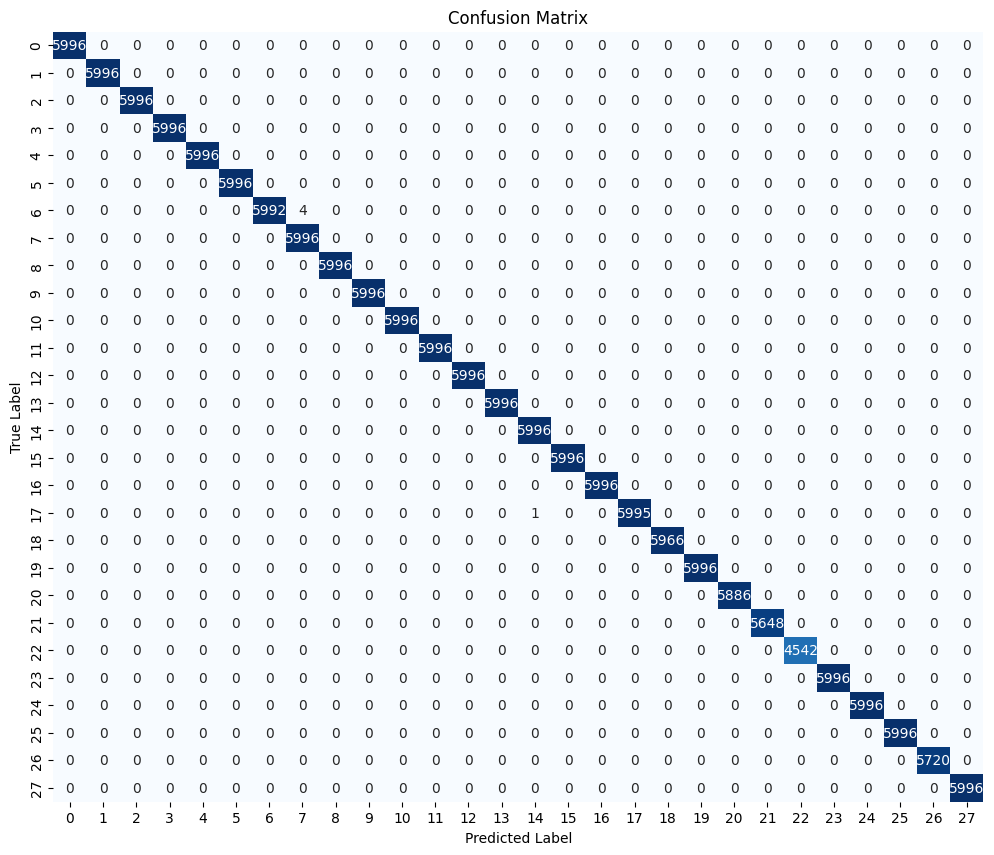

In [33]:
plot_confusion_matrix(y_true, y_pred, class_names)